##### Luca Mattiazzi 709638

# Introduzione

Questa relazione si propone di illustrare tecniche di analisi statistica multivariata applicata a Wines, un dataset che racchiude i dati ottenuti del campionamento del terreno di coltivazione e l’analisi qualità di diversi vini.

Di ogni terreno è stata analizzata la concentrazione di 17 diversi elementi, le variabili indipendenti, ed è stato ottenuto l’aroma del vino prodotto, una variabile dipendente, che rappresenta con un valore da 1 a 10 le proprietà organolettiche date da un sommelier.

L’aroma suddivide inoltre gli oggetti in 2 classi, quella dei vini con valore inferiore a 5 e quella dei vini con valore superiore a 5: ci si interroga se esista una correlazione tra le variabili indipendenti e l’aroma, e quindi l’appartenenza ad una delle due classi, e se sia possibile costruire un modello predittivo della variabile dipendente a partire dai soli valori di tutte, o solo alcune, variabili indipendenti.

# Preparazione dei dati

La prima parte del lavoro consiste nell’analisi “classica” dei dati, ovvero nell’affrontare con metodi non multivariati i dati in nostro possesso per estrarre informazione utile all’obbiettivo finale. 

Questo è un estratto dei valori del dataset WINES:

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import dendrogram
import scipy.stats as stats
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df = pd.read_csv("./tam.csv", delimiter=";")
df = df.drop("#", axis=1)
df["Id"] = df.index + 1
df.head()

,Cd,Mo,Mn,Ni,Cu,Al,Ba,Cr,Sr,Pb,B,Mg,Si,Na,Ca,P,K,Aroma,Class,Id
0,0.005,0.044,1.510,0.122,0.830,0.982,0.387,0.029,1.230,0.561,2.630,128.000,17.300,66.800,80.500,150.000,1130,3.800,1,1
1,0.055,0.160,1.160,0.149,0.066,1.020,0.312,0.038,0.975,0.697,6.210,193.000,19.700,53.300,75.000,118.000,1010,4.400,1,2
2,0.056,0.146,1.100,0.088,0.643,1.290,0.308,0.035,1.140,0.730,3.050,127.000,15.800,35.400,91.000,161.000,1160,3.900,1,3
3,0.063,0.191,0.959,0.380,0.133,1.050,0.165,0.036,0.927,0.796,2.570,112.000,13.400,27.500,93.600,120.000,924,3.900,1,4
4,0.011,0.363,1.380,0.160,0.051,1.320,0.380,0.059,1.130,1.730,3.070,138.000,16.700,76.600,84.600,164.000,1090,5.600,2,5


La tabella dei valori completa è presente alla fine del documento.

I valori ottenuti dalle misurazioni devono essere trasformati prima di poter essere utilizzati o anche solamente visualizzati assieme, questo perché alcuni elementi sono presenti in quantità che sono ordini di grandezza superiore ad altre, e questo renderebbe impossibile comparare due variabili su diversi campioni.

## Scaling

Si risolve questo problema con la scalatura dei dati, una classe di trasformazioni reversibili che ci consentono di rendere paragonabili i domini di variabili diverse, sostituendo i valori originali delle misurazioni con valori che mantengono invariati i rapporti all’interno della stessa variabile, ma cambiano quelli tra variabili diverse.

I metodi che vedremo fanno uso di due indici molto comuni usati per descrivere alcune proprietà di un dataset, la media aritmetica e la deviazione standard.

La media aritmetica si ottiene sommando tutti i valori di una variabile e dividendo il risultato per il numero di osservazioni: questo ci restituisce un numero che, in alcune situazioni, ci consente di farci un’idea del valore intorno al quale una variabile tende a ritrovarsi.

La deviazione standard si ottiene invece sommando il quadrato delle differenze, per ogni osservazione, tra la misurazione e la media aritmetica della variabile. Questa somma viene poi divisa per il numero totale di osservazioni e se ne estrae la radice quadrata. Il valore ottenuto rappresenta quanto la distribuzione di valori della variabile tende ad allontanarsi dalla media aritmetica. 

Questi due parametri definiscono proprietà importanti di una variabile, più avanti vedremo come ci permettano di trarre informazioni primitive dai nostri dati.

Di seguito elenchiamo alcuni metodi di scaling che usano questi due descrittori (per tutte: x’ rappresenta il nuovo valore scalato):


### Centratura

$$
x' = x - \overline{x}
$$

Questo metodo serve per centrare sull’origine la distribuzione dei valori della variabile: è infatti facile intuire che la media dei nuovi valori scalati sarà pari a 0; non cambia invece la deviazione standard.

### Varianza unitaria

$$
x' = \frac{x}{\sigma} 
$$
Come dice il nome stesso, trasforma la deviazione standard dei valori scalati per portarla ad 1, e poiché applica una divisione ad ogni valore, anche la media risulterà divisa per lo stesso valore.

### Auto scaling

$$
x' = \frac{x - \overline{x}}{\sigma}
$$

Questa tecnica è una delle più utilizzate, ed è la combinazione delle due formule sopra descritte: la media dei valori scalati è pari a 0, e deviazione standard e varianza sono pari ad 1.

### Scaling al valore massimo

$$
x' = \frac{x}{max(x)}
$$

Si dividono tutti i valori per il valore massimo assunto dalla variabile in questione in modo che il valore massimo della variabile risulti pari a 1.

### Scaling a intervallo

$$
x' = \frac{x - min(x)}{max(x) - min(x)}
$$

Come nel caso precedente, il valore massimo della variabile scalata risulterà pari ad 1, ma in questo caso il valore minimo risulterà 0. Questo consente di scalare qualsiasi variabile al dominio \[0, 1\].


Nel nostro caso, qualora decidessimo di procedere ad utilizzare i valori che abbiamo senza applicare alcuna trasformazione, rischieremmo di dare troppa importanza ad alcune misurazioni per le quali il valore assoluto è decisamente più alto rispetto ad altre (vedi Magnesio e Cadmio, che differiscono di diversi ordini di grandezza), nonostante questo possa in realtà non avere importanza ai nostri fini.

Per questo applichiamo auto scaling alle nostre variabili indipendenti, evitando di trasformare la variabile dipendente, in quanto si tratta del nostro output, e la classe, che rappresenta in realtà una variabile categorica e che quindi non ha senso assuma valori diversi da quelli che possiede.

# Analisi delle variabili

## Analisi dei dati univariata

Una prima analisi che possiamo effettuare sui dati in nostro possesso è il calcolo e la visualizzazione delle medie e delle deviazioni standard dei campioni, controllando se esista qualche differenza tra le due classi.

### Media e Deviazione Standard

Di seguito vediamo media e deviazione standard per tutti i campioni:

In [2]:
df_1 = df[df["Class"] == 1]
df_2 = df[df["Class"] == 2]
classes_to_remove = ["Class", "Aroma", "Id"]

def get_desc(df0, classes_to_remove = classes_to_remove):
    means = df0.drop(classes_to_remove, axis=1).mean().values
    stds = df0.drop(classes_to_remove, axis=1).std().values
    rows = df0.drop(classes_to_remove, axis=1).columns
    df_desc = pd.DataFrame(list(zip(means, stds)), index=rows, columns=["mean", "std"])
    return df_desc

get_desc(df).transpose()

,Cd,Mo,Mn,Ni,Cu,Al,Ba,Cr,Sr,Pb,B,Mg,Si,Na,Ca,P,K
mean,0.052,0.172,1.691,0.104,0.171,0.874,0.231,0.044,0.899,0.839,4.728,129.450,14.331,41.839,76.287,156.171,1119.237
std,0.025,0.099,0.649,0.085,0.196,0.403,0.105,0.020,0.550,0.475,1.648,32.048,8.557,30.524,19.085,33.799,195.046


Questi sono invece i valori solo per la classe 1:

In [3]:
get_desc(df_1).transpose()

,Cd,Mo,Mn,Ni,Cu,Al,Ba,Cr,Sr,Pb,B,Mg,Si,Na,Ca,P,K
mean,0.050,0.152,1.665,0.108,0.173,0.924,0.273,0.044,1.158,0.745,4.446,143.213,15.931,50.257,81.487,156.370,1177.957
std,0.026,0.100,0.608,0.070,0.231,0.388,0.079,0.024,0.493,0.475,1.774,30.359,7.843,32.813,19.282,40.114,202.049


Questi quelli per la classe 2:

In [4]:
get_desc(df_2).transpose()

,Cd,Mo,Mn,Ni,Cu,Al,Ba,Cr,Sr,Pb,B,Mg,Si,Na,Ca,P,K
mean,0.056,0.203,1.730,0.099,0.166,0.797,0.166,0.044,0.501,0.984,5.161,108.347,11.877,28.933,68.313,155.867,1029.200
std,0.025,0.093,0.727,0.107,0.134,0.425,0.110,0.014,0.370,0.451,1.380,21.857,9.285,21.809,16.305,22.145,148.457


Possiamo quindi vedere la percentuale di differenza tra le medie delle variabili nella classe 1 e la classe 2 per farci un'idea di quali siano quelle che potrebbero impattare di più l'appartenenza ad una classe.

In [5]:
vals = 100 * (get_desc(df_2)["mean"] - get_desc(df_1)["mean"]) / get_desc(df_1)["mean"]
pd.DataFrame(vals.values, index=vals.index, columns=["delta"]).transpose()

,Cd,Mo,Mn,Ni,Cu,Al,Ba,Cr,Sr,Pb,B,Mg,Si,Na,Ca,P,K
delta,11.842,33.404,3.917,-8.347,-4.095,-13.821,-39.121,0.386,-56.730,31.995,16.083,-24.346,-25.451,-42.429,-16.167,-0.322,-12.628


Ad una prima analisi superficiale, quindi, sembrerebbe che Sr, Na e Ba siano i tre elementi con maggiore differenza tra le due classi; basandoci però sulla media aritmetica, ed avendo un numero limitato di valori, un singolo outlier potrebbe cambiare drasticamente questo risultato, che possiamo usare solo come suggerimento per il resto dell'analisi.

### Dati scalati

Possiamo quindi passare a visualizzare i dati che abbiamo con dei grafici univariati. Questi non ci consentiranno di avere informazioni circa il rapporto tra diverse variabili, ma solo come si comporta la singola variabile.

In particolare, per osservare la distribuzione di una variabile, risulta molto efficace l'uso del violin plot con un box plot: il primo serve a visualizzare qualitativamente quanto certi valori siano più rappresentati, il secondo invece mostra i quantili della distribuzione.

Come prima cosa però, applichiamo autoscaling alle nostre variabili, in quanto sarebbe impossibile visualizzarne le caratteristiche correttamente se mantenessero i loro valori originali, di ordini di grandezza troppo diversi per essere paragonabili.

Questo è un estratto dal dataset normalizzato:

In [6]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df.drop(classes_to_remove, axis=1))
scaled_df = pd.DataFrame(data= scaled,
                     columns= df.drop(classes_to_remove, axis=1).columns)
scaled_df = scaled_df.assign(Class=df["Class"].values, Aroma=df["Aroma"].values)
scaled_df.head()


,Cd,Mo,Mn,Ni,Cu,Al,Ba,Cr,Sr,Pb,B,Mg,Si,Na,Ca,P,K,Class,Aroma
0,-1.919,-1.306,-0.283,0.213,3.401,0.272,1.508,-0.733,0.611,-0.594,-1.290,-0.046,0.352,0.829,0.224,-0.185,0.056,1,3.800
1,0.102,-0.121,-0.829,0.535,-0.540,0.368,0.785,-0.282,0.141,-0.304,0.911,2.010,0.636,0.380,-0.068,-1.145,-0.568,1,4.400
2,0.143,-0.264,-0.923,-0.192,2.437,1.047,0.746,-0.432,0.445,-0.233,-1.032,-0.077,0.174,-0.214,0.781,0.145,0.212,1,3.900
3,0.425,0.195,-1.143,3.286,-0.194,0.443,-0.633,-0.382,0.052,-0.092,-1.327,-0.552,-0.110,-0.476,0.919,-1.085,-1.014,1,3.900
4,-1.676,1.952,-0.486,0.666,-0.617,1.123,1.440,0.770,0.426,1.902,-1.019,0.270,0.281,1.154,0.441,0.235,-0.152,2,5.600


### Violin Plot

Partendo da questi valori, possiamo plottare un violinplot suddiviso per classi che evidenzi i quartili:

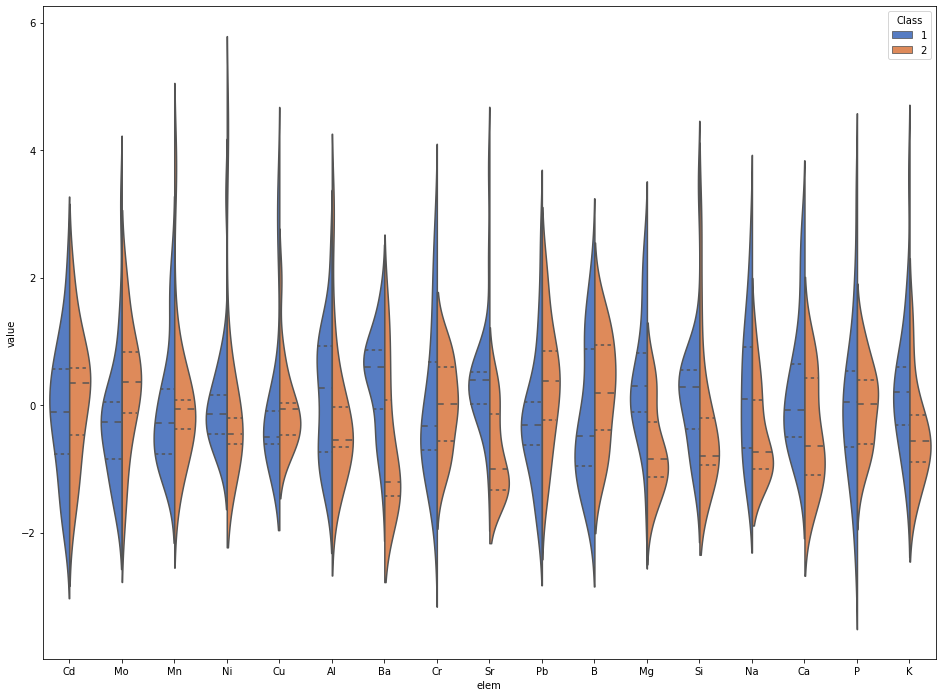

In [7]:
violin_df = scaled_df.drop(["Aroma"], axis=1).melt(id_vars=["Class"], var_name="elem")

plt.rcParams["figure.figsize"] = (16, 12)
ax = sns.violinplot(data=violin_df, x="elem", y="value", palette="muted", hue="Class", split=True, inner="quart", saturation=0.8)

In questo grafico possiamo vedere le distribuzioni dei dati per le due diverse classi a confronto per ogni elemento. Inoltre, grazie alla scalatura dei dati, possiamo vedere anche quali elementi abbiano una varianza maggiore. Le linee tratteggiate all'interno delle curve rappresentano il 25, 50 e 75 quantili, utili ad identificare la distribuzione dei dati.

Ad una prima vista, possiamo vedere come gli elementi Mo, Ba, Cr, Sr, Pb, Mg e Si spicchino per distribuzioni con mode differenti tra le due classi, il che potrebbe portarci a considerarli importanti nella discriminazione tra esse. Inoltre vediamo come alcuni valori, P su tutti, sembrino avere pochissime differenze tra i campioni e tra le classi, indice che potrebbero essere poco influenti ai nostri fini.

## Analisi dei dati multivariata

Ora possiamo passare a fare un'analisi dei dati che prenda in considerazione più variabili a confronto.

### Covarianza

La prima analisi che effettuiamo è il calcolo della covarianza tra le variabili; la covarianza è un valore numerico che rappresenta quanto due variabili tendino a variare assieme in campioni diversi.

$$
\sigma_xy = \frac{1}{N}\sum_{i=1}^N(x_i-\bar{x})(y_i-\bar{y})
$$

Il suo valore è la media dei prodotti, per ogni campione, degli scarti delle due variabili.
Dalla covarianza possiamo calcolare un indice di correlazione per costruire quella che si chiama Matrice di Correlazione: una matrice che rappresenta quanto tutte le variabili siano correlate tra di loro a coppie.

### Matrice di Correlazione

Utilizziamo come indice la correlazione di Pearson, che assume valori che possono andare da -1 a 1; la correlazione sarà prossima a -1 in caso di variabili inversamente correlate, ad 1 in caso di variabili direttamente correlate, e intorno a 0 in caso di correlazione bassa o assente.

$$
\rho_xy = \frac{\sigma_xy}{\sigma_x \sigma_y}
$$

Poichè però utilizziamo valori autoscalati, che hanno quindi varianza pari ad 1, nel nostro caso la correlazione di Pearson risulta pari alla covarianza.

Bisogna sottolineare però che la correlazione di Pearson è in grado di rilevare solo relazioni lineari o perlomeno rappresentate da una funzione monotona e continua: due variabili possono invece avere un rapporto di correlazione diverso, ma l'indice potrebbe comunque risultare pari a 0 in quel caso; per questo, a parte un'analisi numerica più approfondita, l'uso di analisi visiva è molto importante.

In [8]:
scaled_df.corr()

,Cd,Mo,Mn,Ni,Cu,Al,Ba,Cr,Sr,Pb,B,Mg,Si,Na,Ca,P,K,Class,Aroma
Cd,1.000,0.387,0.211,-0.153,-0.277,-0.270,-0.087,0.049,-0.235,0.436,0.068,-0.078,-0.080,-0.350,0.016,-0.348,-0.173,0.117,0.156
Mo,0.387,1.000,0.031,0.249,0.157,-0.119,-0.050,0.323,-0.180,0.953,-0.069,0.148,0.040,-0.049,0.386,0.050,-0.149,0.253,0.193
Mn,0.211,0.031,1.000,-0.354,-0.186,-0.317,0.222,0.292,0.325,0.049,-0.094,0.127,-0.253,-0.004,-0.463,0.033,0.110,0.050,-0.042
Ni,-0.153,0.249,-0.354,1.000,0.035,-0.021,0.147,0.065,0.098,0.211,-0.156,0.212,0.245,-0.096,0.416,0.091,-0.042,-0.052,-0.149
Cu,-0.277,0.157,-0.186,0.035,1.000,0.019,-0.102,0.055,-0.143,0.134,-0.075,-0.062,0.044,0.083,0.208,0.081,-0.064,-0.018,-0.044
Al,-0.270,-0.119,-0.317,-0.021,0.019,1.000,0.043,-0.200,-0.010,-0.116,-0.295,-0.094,-0.161,0.248,0.112,-0.234,-0.145,-0.157,-0.193
Ba,-0.087,-0.050,0.222,0.147,-0.102,0.043,1.000,0.090,0.753,0.043,-0.270,0.643,0.361,0.436,0.220,0.036,0.503,-0.503,-0.609
Cr,0.049,0.323,0.292,0.065,0.055,-0.200,0.090,1.000,0.378,0.252,0.040,0.381,0.061,0.430,0.066,0.453,0.497,0.004,-0.161
Sr,-0.235,-0.180,0.325,0.098,-0.143,-0.010,0.753,0.378,1.000,-0.167,-0.326,0.773,0.160,0.523,0.180,0.376,0.617,-0.592,-0.761
Pb,0.436,0.953,0.049,0.211,0.134,-0.116,0.043,0.252,-0.167,1.000,-0.157,0.126,0.068,-0.078,0.356,0.032,-0.168,0.249,0.171


### Heatmap di correlazione

Per rendere più semplice l'analisi della matrice ottenuta, possiamo visualizzare una heatmap della matrice stessa: si tratta di una matrice in cui il colore di ogni cella rappresenta il valore al suo interno:

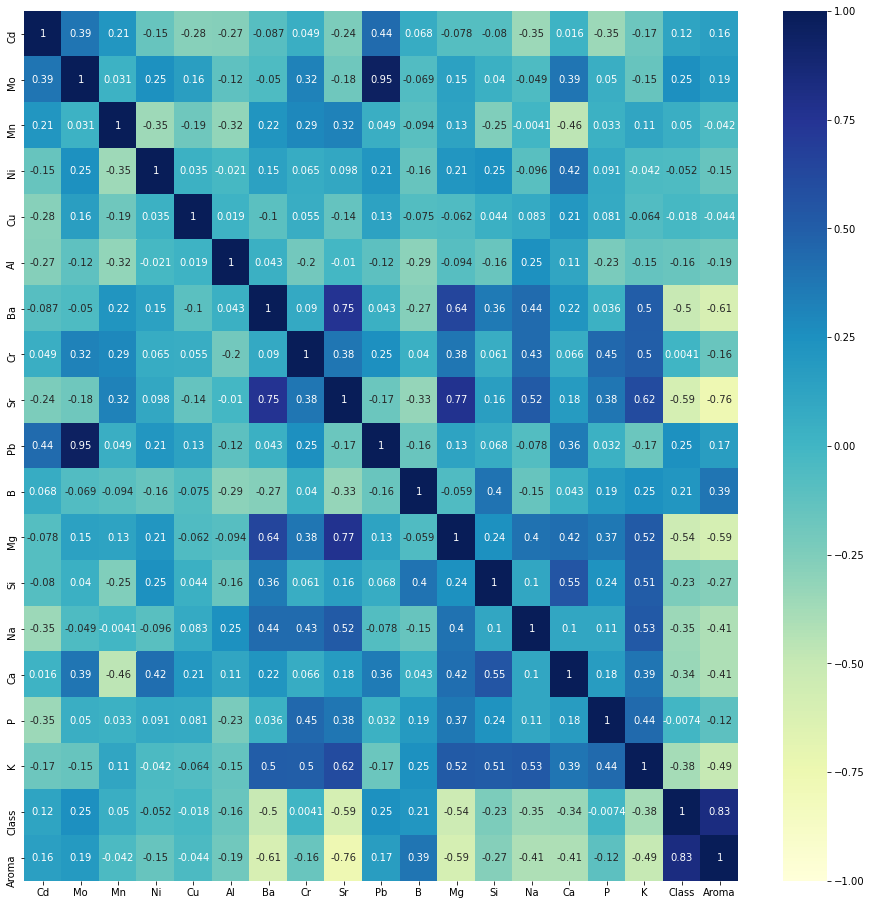

In [9]:
plt.rcParams["figure.figsize"] = (16, 16)
ax = sns.heatmap(scaled_df.corr(), annot=True, vmin=-1, vmax=1 ,cmap="YlGnBu")

Possiamo subito identificare i valori maggiori e minori rappresentati dai colori molto chiari e molto scuri, e vediamo come Sr abbia una forte correlazione inversa con Aroma, come anche, in minor misura, Ba. Nessun elemento sembra aver una correlazione diretta con Aroma o Class. La correlazione di valore assoluto maggiore che vediamo subito è quella tra Pb e Mo, e quella ovvia tra Class e Aroma.

### Pairplot e Scatterplot

Per visualizzare facilmente i valori di due variabili per tutti i nostri campioni utilizziamo lo scatterplot. In uno scatterplot ad ogni punto corrisponde un campione, e le due coordinate rappresentano due variabili del dataset.

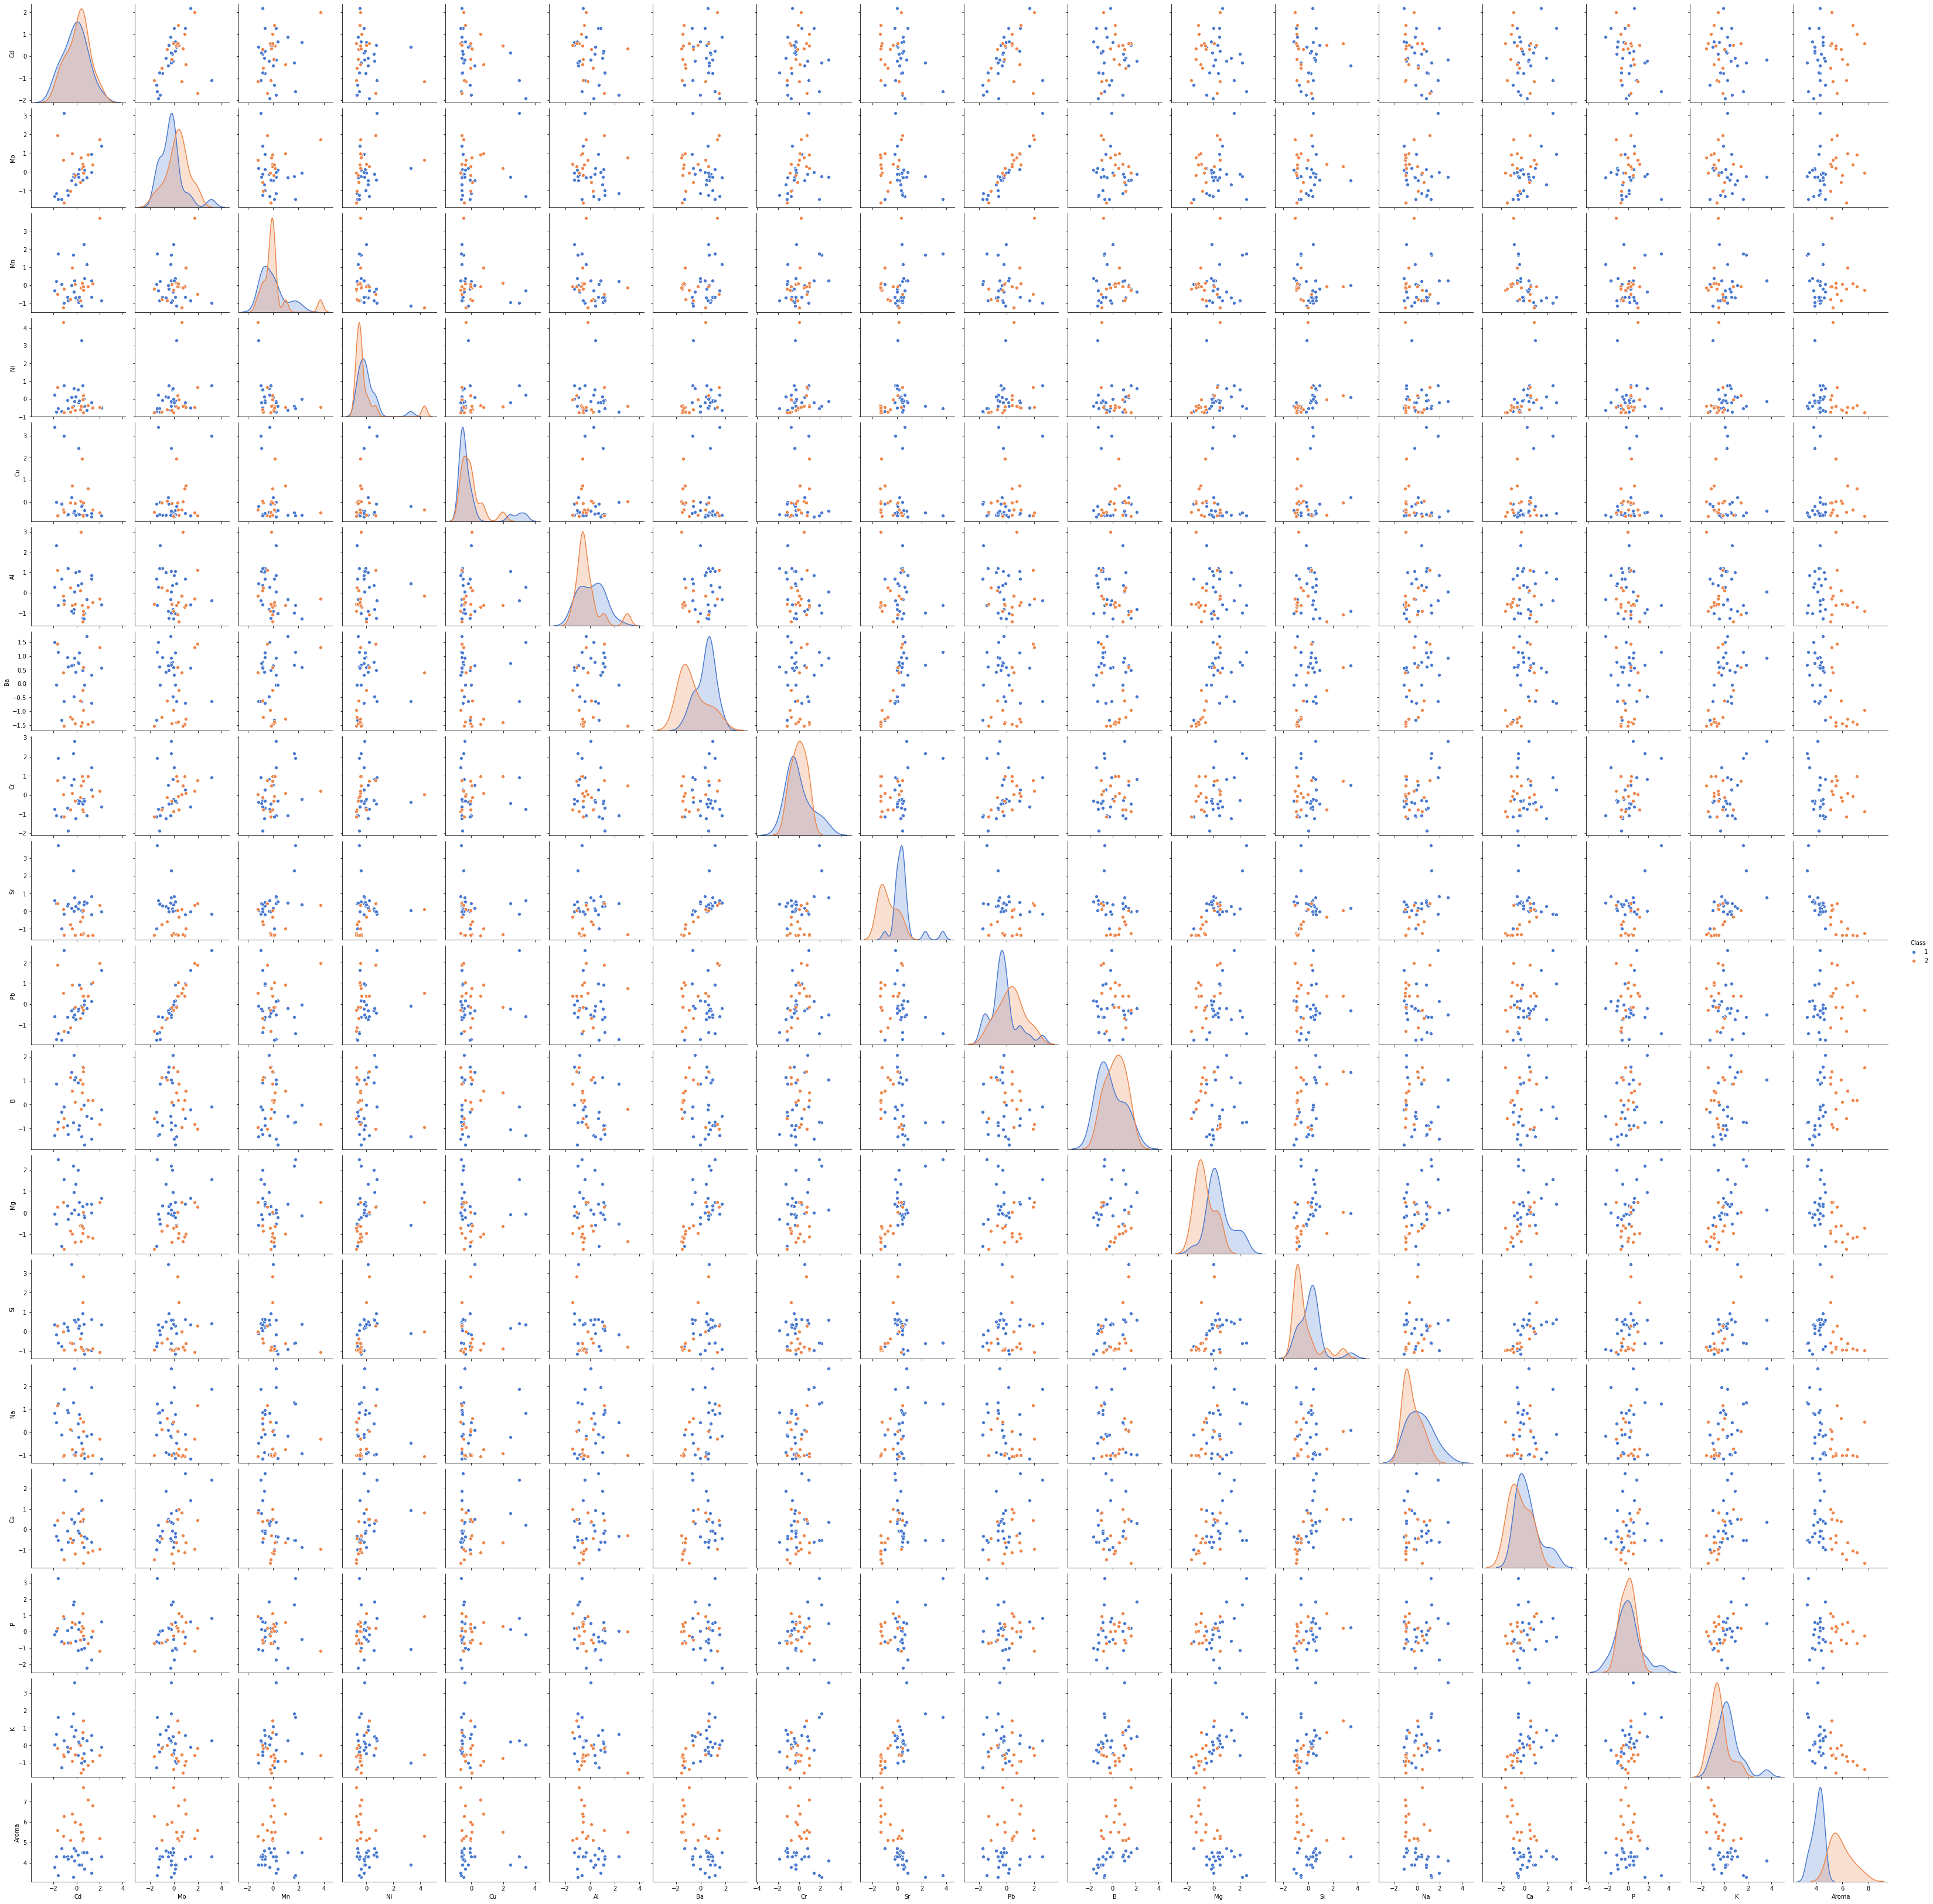

In [10]:
plt.rcParams["figure.figsize"] = (16, 16)
plt.interactive(False)
ax = sns.pairplot(scaled_df, hue="Class", palette="muted")

Quello che vediamo è un pairplot, una matrice che rappresenta, per ogni coppia di variabili, uno scatterplot, e lungo la diagonale la distribuzione dei valori per la variabile. In questo caso abbiamo anche separato le due classi per colore, in modo da evidenziare sia le differenze tra le distribuzioni all'interno di una variabile, sia tra due variabili diverse.

Lo scatterplot ci consente di confermare le correlazioni tra i dati ottenute nella matrice: possiamo infatti vedere che lo scatterplot tra Pb e Mo (0.95) mostri una chiara correlazione diretta e i punti nel grafico sembrano seguire una linea diagonale crescente.

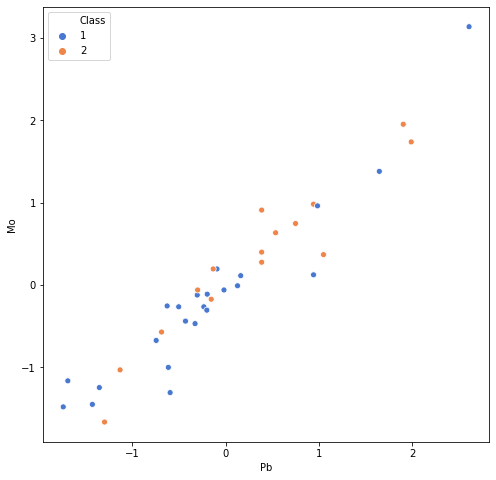

In [11]:
plt.rcParams["figure.figsize"] = (8, 8)
ax = sns.scatterplot(data=scaled_df, hue="Class", x="Pb", y="Mo", palette="muted")

Lo scatterplot ci conferma anche la correlazione inversa tra Aroma e Sr

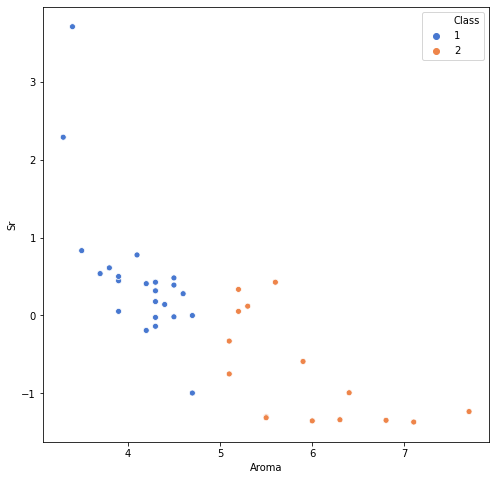

In [12]:
plt.rcParams["figure.figsize"] = (8, 8)
ax = sns.scatterplot(data=scaled_df, hue="Class", x="Aroma", y="Sr", palette="muted")

Lo scatterplot suggerisce, in aggiunta al valore della matrice, che la correlazione potrebbe non essere lineare, ma iperbolica; poichè l'iperbole, nonostante non sia lineare, è monotona, la correlazione di Pearson è in grado di identificarla.

Come Sr, anche Ba, Mg e K sono inversamente correlati con il valore di Aroma, anche se gli scatterplot sono meno evidenti; quello che si può apprezzare è come, negli scatterplot, sia molto raro trovare campioni di classe 2 (quindi con un valore di aroma alto) a coordinate in cui entrambe le variabili sono alte: questo suggerisce che alte concentrazioni di questi elementi siano, per la maggior parte dei casi, negative per l'aroma.

La presenza di una correlazione tra le due variabili non ci suggerisce la causa di tale correlazione: potrebbe semplicemente significare che i minerali che contengono Pb contengano anche Mo, e di conseguenza nei terreni in cui è presente l'uno si trova anche l'altro; o che tendono a fissarsi in terreni a pH simili, o a formare sali con altri elementi dei quali non abbiamo dati.

## PCA - Analisi delle Componenti Principali

### Introduzione

L'analisi delle componenti principali è una tecnica utilizzata, tra le altre cose, per ridurre le dimensioni di un dataset; le dimensioni, o features, sono le colonne di un dataset. Ridurle significa perdere informazione circa il dataset stesso, di conseguenza l'applicazione della PCA si propone come obbiettivo quello di cercare di mantenere la maggior quantità di informazione utile nonostante la perdita di dimensioni.

Applicare la PCA porta all'identificazione di nuove dimensioni mediante un processo di rotazione della matrice dei dati, che prendono il nome di Componenti Principali (PC). La peculiarità di queste PC è che sono ordinate per varianza e che sono tutte perpendicolari tra di loro nello spazio n-dimensionale del dataset. Il fatto che siano ortogonali significa che la covarianza tra tutte le PC è sempre 0.

Il primo step consiste nel calcolo di autovettori e autovalori della matrice di correlazione del dataset; si tratta di valori caratteristici delle matrici quadrate (quale quella di correlazione), in particolare sono tanti vettori e tanti scalari quante le dimensioni della matrice.

Ogni PC è caratterizzata da un autovettore e un autovalore; l'autovettore, o loadings, rappresenta i coefficienti da assegnare ad ogni variabile originaria per ottenere la PC con una combinazione lineare, mentre l'autovalore è la varianza che questa PC spiega.

A questo punto è sufficiente ordinare le PC per autovalore e si ottiene la lista delle nuove coordinate ordinate per varianza, perpendicolari tra di loro e ottenute da una combinazione lineare delle variabili originarie.

### Tabella PC

Applicando la PCA senza limitare il numero di PC finali otteniamo un dataset in cui ogni campione avrà una coordinata per ogni nuova variabile. Fino a questo punto non abbiamo perso informazione e potremmo tornare allo stato precedente applicando la trasformazione inversa.

Ecco un estratto del dataset ruotato:

In [13]:
pca = PCA()
pca_df = pca.fit_transform(scaled_df.drop(["Aroma", "Class"], axis=1))
pca_df = pd.DataFrame(pca_df)
pc_names = [f"PC{i + 1}" for i in range(len(pca.explained_variance_))] 
pca_df = pd.DataFrame(pca_df)
pca_df.columns = pc_names
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
0,1.142,-1.498,-2.106,-1.631,1.367,0.344,3.172,0.375,-0.075,-0.198,0.117,-0.328,0.308,-0.004,-0.063,-0.346,0.186
1,0.754,-0.044,-0.715,-0.323,-1.540,-0.277,-0.292,0.365,-0.182,2.007,0.378,-0.782,-0.662,0.347,-0.225,0.063,-0.048
2,0.462,0.065,-1.568,-1.262,0.600,-0.369,1.664,-0.740,-0.910,-0.845,0.384,-0.852,0.495,-0.063,0.150,0.218,-0.113
3,-0.917,1.407,-1.752,-1.842,-0.961,1.740,-0.939,1.581,-0.820,-0.563,0.487,0.234,-0.178,-0.695,0.107,0.196,0.069
4,1.873,1.505,-0.397,-2.268,0.672,-0.224,-0.856,0.149,2.105,0.242,-0.610,0.210,0.090,0.826,0.493,-0.155,-0.058


Ogni nuova coordinata è una combinazione lineare delle coordinate del dataset originario per quel campione, ed il coefficiente di ogni dimensione originale è rappresentato nella tabella dei loadings:

In [14]:
pd.DataFrame(pca.components_, columns=scaled_df.drop(["Aroma", "Class"], axis=1).columns, index=pc_names).head()

,Cd,Mo,Mn,Ni,Cu,Al,Ba,Cr,Sr,Pb,B,Mg,Si,Na,Ca,P,K
PC1,-0.125,0.034,0.056,0.109,0.004,-0.039,0.353,0.271,0.415,0.030,-0.020,0.405,0.239,0.303,0.233,0.256,0.403
PC2,0.285,0.546,-0.118,0.247,0.122,-0.130,-0.080,0.118,-0.187,0.537,0.034,0.048,0.142,-0.161,0.333,0.024,-0.097
PC3,0.351,0.150,0.571,-0.268,-0.219,-0.278,0.061,0.266,0.134,0.168,-0.091,0.075,-0.282,-0.019,-0.339,-0.015,-0.011
PC4,0.055,-0.125,0.022,-0.140,-0.065,-0.420,-0.229,0.101,-0.166,-0.161,0.618,-0.084,0.308,-0.194,-0.022,0.289,0.243
PC5,-0.369,0.132,0.011,-0.107,0.496,0.047,-0.348,0.394,-0.085,0.064,-0.052,-0.111,-0.276,0.228,-0.140,0.368,-0.029


### Scelta delle PC

Ottenute le PC passiamo a scegliere quali vogliamo mantenere durante la nostra analisi del dataset, mentre le altre verranno scartate e l'informazione che contengono persa. Consideriamo la varianza come indice di informazione che ogni PC contiene, e la PCA ci offre per questo due vantaggi: le PC sono totalmente indipendenti tra di loro, quindi non rischiamo di avere informazione duplicata, e sono ordinate per varianza decrescente; in questo modo scegliere quali mantenere significa solamente scegliere un threshold oltre il quale scartare le PC.

Qui vediamo i valori di varianza, di varianza proporzionale e di varianza proporzionale cumulata per le PC che abbiamo ottenuto:

In [15]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
var_df = pd.DataFrame(list(zip(pca.explained_variance_, pca.explained_variance_ratio_, cumulative_variance)), index=pc_names, columns=["Varianza", "Varianza proporzionale", "Varianza proporzionale cumulata" ])
var_df.transpose()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
Varianza,4.291,2.821,2.270,1.987,1.474,1.111,0.876,0.625,0.527,0.440,0.381,0.261,0.173,0.118,0.051,0.034,0.020
Varianza proporzionale,0.246,0.162,0.130,0.114,0.084,0.064,0.050,0.036,0.030,0.025,0.022,0.015,0.010,0.007,0.003,0.002,0.001
Varianza proporzionale cumulata,0.246,0.407,0.537,0.651,0.736,0.799,0.849,0.885,0.915,0.941,0.962,0.977,0.987,0.994,0.997,0.999,1.000


Questo invece è lo scree plot, un line plot che rappresenta la varianza di ogni PC:

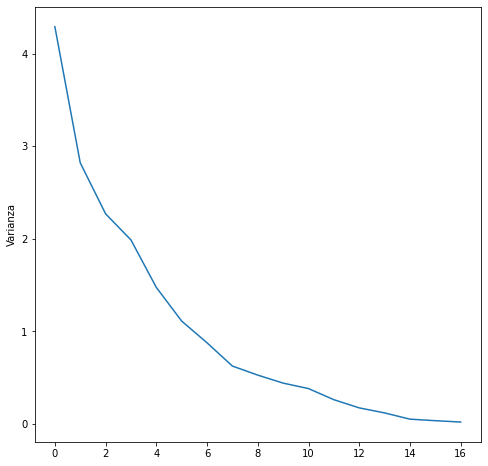

In [16]:
plt.rcParams["figure.figsize"] = (8, 8)
ax = sns.lineplot(data=var_df, y="Varianza", x=range(17), markers=True)

Per scegliere quali PC scartare esistono 3 metodi:

#### Scree Plot

Basandosi sullo scree plot, si sceglie la variabile che corrisponde al punto in cui il grafico effettua la curva che lo porta ad essere quasi orizzontale: la lenta discesa della varianza nelle PC rimanenti risulta, generalmente, dal fatto che sia una varianza motivata dal rumore e non da informazione utile.
Nel nostro caso, terremmo le prime 7 PC.

#### Autovalore Medio

Si utilizzano solamente le variabili la cui varianza sia superiore alla media delle varianze; poichè nel nostro caso è stata applicato autoscaling, che ha portato le variabili originarie ad avere varianza 1, la varianza totale delle PC è pari al numero delle PC stesse (la varianza è mantenuta nella rotazione che ci porta alle PC infatti). Di conseguenza ci basta scegliere solo le PC la cui varianza sia superiore ad 1.
Nel nostro caso, terremmo le prime 6 PC.

#### Varianza cumulata

In questo caso si fa una scelta più soggettiva e si decide un threshold di varianza da mantenere (e.g. 80%) e si scelgono le PC la cui somma cumulata di varianza raggiunga almeno questo valore.
Nel nostro caso terremmo le prime 7 PC (per arrivare ad 80%).

### Analisi dei loadings

Decidiamo di prendere in considerazione le prime 7 PC, la cui somma delle varianze consente di mantenere circa l'85% della varianza del dataset iniziale, riducendo a meno della metà le dimensioni.

Considerando le PC scartate come contenenti varianza dovuta ad informazione spuria, o poco utile ai nostri fini, una prassi che viene utilizzata è quella di applicare la trasformazione inversa per ritornare ai dati originali privi di questo "rumore di fondo" che abbiamo attribuito a variazioni non importanti.

Ora possiamo analizzare la tabella dei loadings per vedere come ogni variabile originaria si rifletta nelle PC che abbiamo scelto.

In [17]:
loadings = pd.DataFrame(pca.components_, columns=scaled_df.drop(["Aroma", "Class"], axis=1).columns, index=pc_names).head(7)
loadings

,Cd,Mo,Mn,Ni,Cu,Al,Ba,Cr,Sr,Pb,B,Mg,Si,Na,Ca,P,K
PC1,-0.125,0.034,0.056,0.109,0.004,-0.039,0.353,0.271,0.415,0.030,-0.020,0.405,0.239,0.303,0.233,0.256,0.403
PC2,0.285,0.546,-0.118,0.247,0.122,-0.130,-0.080,0.118,-0.187,0.537,0.034,0.048,0.142,-0.161,0.333,0.024,-0.097
PC3,0.351,0.150,0.571,-0.268,-0.219,-0.278,0.061,0.266,0.134,0.168,-0.091,0.075,-0.282,-0.019,-0.339,-0.015,-0.011
PC4,0.055,-0.125,0.022,-0.140,-0.065,-0.420,-0.229,0.101,-0.166,-0.161,0.618,-0.084,0.308,-0.194,-0.022,0.289,0.243
PC5,-0.369,0.132,0.011,-0.107,0.496,0.047,-0.348,0.394,-0.085,0.064,-0.052,-0.111,-0.276,0.228,-0.140,0.368,-0.029
PC6,-0.233,-0.096,0.072,0.552,-0.061,-0.352,-0.013,-0.087,0.168,-0.091,-0.224,0.115,-0.123,-0.438,-0.116,0.342,-0.231
PC7,-0.049,-0.055,0.236,-0.201,0.705,-0.346,0.301,-0.303,0.020,0.023,-0.088,-0.022,0.209,-0.101,0.006,-0.190,-0.023


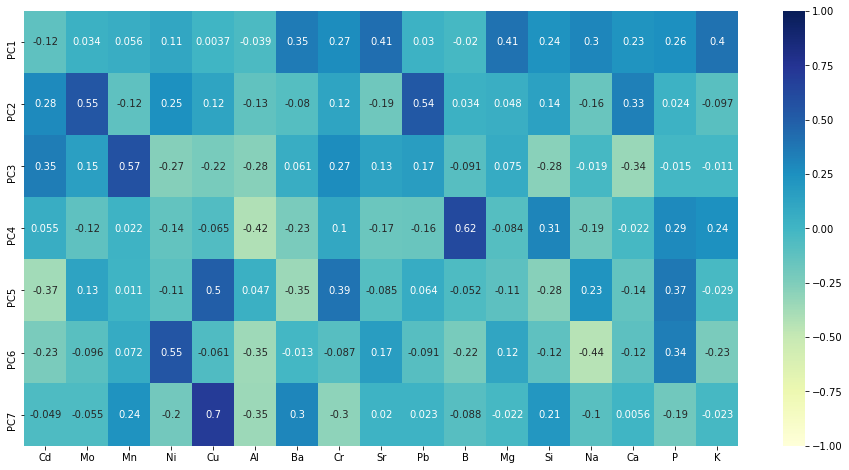

In [18]:
plt.rcParams["figure.figsize"] = (16, 8)
ax = sns.heatmap(loadings, annot=True, vmin=-1, vmax=1, cmap="YlGnBu")

Per ogni coppia di PC è possibile costruire un loading plot, che rappresenta l'importanza di ogni variabile originaria nella costruzione della PC. Ogni variabile è rappresentata da un vettore che parte dall'origine e arriva alle coordinate dettate dai suoi loadings per la PC di quell'asse; di conseguenza, le variabili originarie più distanti dall'origine sono quelle che più impattano (in positivo o in negativo) il valore delle PC plottate.
Come esempio, questo è il loadings plot delle prime 2 PC:

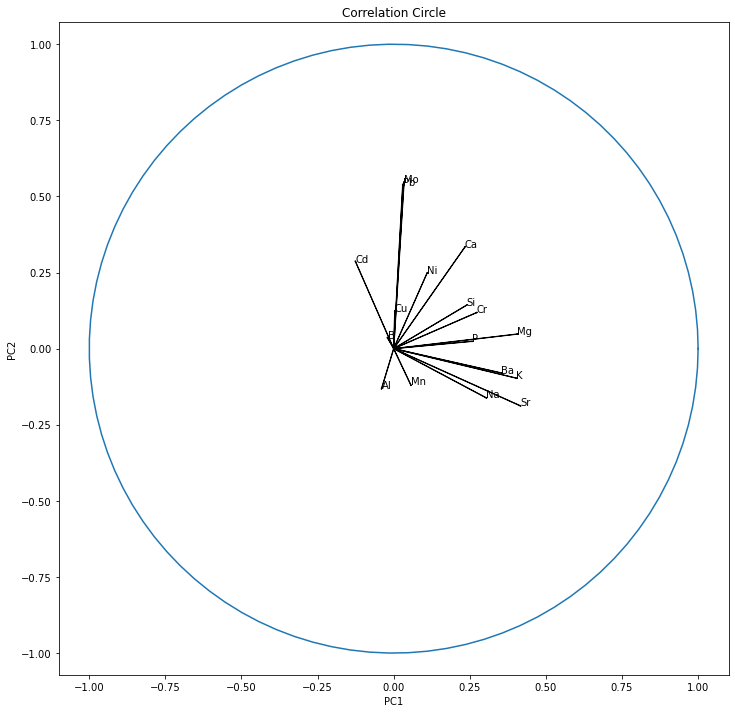

In [19]:
FIG_SIZE = (12, 12)
def plot_correlation_circle(df, pca, pcs):
    (fig, ax) = plt.subplots(figsize=FIG_SIZE)
    for i in range(0, len(pca.components_)):
        loading_pc1 = pca.components_[pcs[0], i]
        loading_pc2 = pca.components_[pcs[1], i]
        text = df.columns.values[i]
        ax.arrow(0,0,loading_pc1,loading_pc2)
        plt.text(loading_pc1,loading_pc2,text)
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))
    plt.axis('equal')
    ax.set_title('Correlation Circle')
    plt.xlabel(f"PC{pcs[0] + 1}")
    plt.ylabel(f"PC{pcs[1] + 1}")
    plt.show()

plot_correlation_circle(scaled_df, pca, (0, 1))

Dal grafico si può vedere come la PC1, che da sola spiega quasi un quarto della varianza totale, abbia come variabili più influenti Mg e Sr, entrambi metalli del secondo gruppo, al quale appertiene anche Ba, anch'esso molto importante per la PC1; si potrebbe supporre che alte concentrazioni minerali che contengano questi tipi di metalli, simili nella loro reattività, siano rappresentate da questa PC.

La PC2 invece segue per la maggior parte gli andamenti di Mo e Pb, che invece risultano ininfluenti dalla PC1; considerando la natura chimica di questi due elementi, che formano entrambi composti con lo zolfo e coesistono come ossido nella wulfenite, è possibile che questa PC indichi la presenza di questo minerale nel terreno o di solfuri.


Nonostante si cerchi di spiegare i loadings delle PC interpretandole come misurazioni indirette di singoli eventi fisici, non è sempre questo il caso: le PC sono anzitutto artefatti matematici, i cui valori possono anche non essere correlati ad un evento fisico, ma dipendere da bias nel dataset o coincidenza di numerosi eventi diversi.

### Analisi della correlazione e scores

Dopo aver analizzato la composizione delle prime due PC, possiamo provare a plottare i campioni su queste nuove variabili per vedere se ci sia una correlazione più marcata con la nostra variabile dipendente: l'aroma.

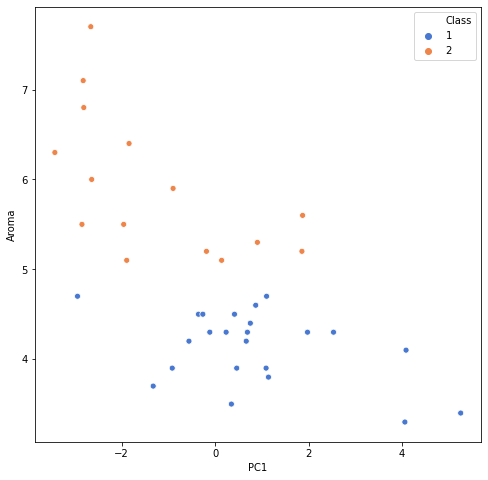

In [20]:
pca_df = pca_df.assign(Class=df["Class"].values, Aroma=df["Aroma"].values)
plt.rcParams["figure.figsize"] = (8, 8)
ax = sns.scatterplot(data=pca_df, hue="Class", x="PC1", y="Aroma", palette="muted")

Possiamo subito vedere come sembri esserci una correlazione inversa tra PC1 ed aroma, nonostante non sia molto netta; si può però individuuare come tutti i campioni con valore di PC1 < -2 appartengano alla classe 2 (eccezion fatta per uno), quindi questa singola variabile ci consente di identificare facilmente un gruppo di campioni che hanno un valore di aroma alto.

Nessuna correlazione appare evidente invece per la PC2:

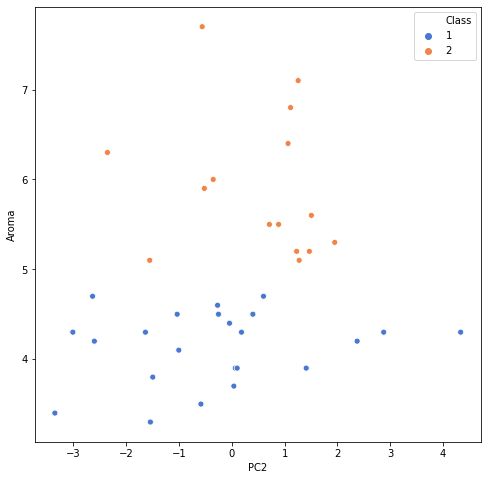

In [21]:
plt.rcParams["figure.figsize"] = (8, 8)
ax = sns.scatterplot(data=pca_df, hue="Class", x="PC2", y="Aroma", palette="muted")

Per certificare questi risultati, possiamo controllare la correlazione tra ogni PC e il valore di aroma, ricordando che la correlazione tra le PC è sempre 0:

In [22]:
pca_df.corr().tail(1).drop(["Aroma", "Class", "PC8", "PC9", "PC10", "PC11", "PC12", "PC13", "PC14", "PC15", "PC16", "PC17"], axis=1)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Aroma,-0.661,0.195,0.107,0.325,0.192,-0.012,-0.121


Non solo vediamo che la PC1 ha una forte correlazione inversa, ma sembra essere l'unica PC che abbia una correlazione tale da essere significativa ai fini della nostra analisi. 

La seconda PC in ordine di valore assoluto è la PC4, che numericamente sembra avere una debole correlazione con l'aroma, ma plottando i valori vediamo che non sembra esserci un andamento netto:

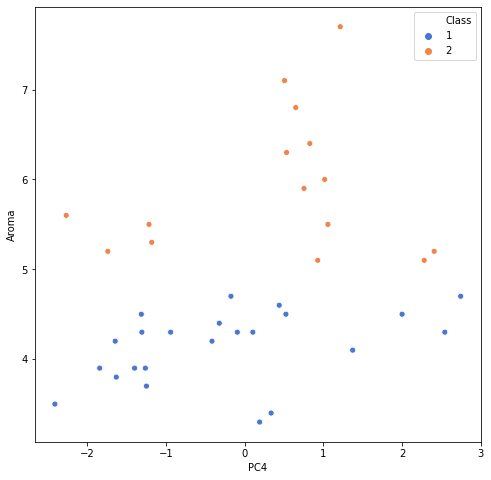

In [23]:
plt.rcParams["figure.figsize"] = (8, 8)
ax = sns.scatterplot(data=pca_df, hue="Class", x="PC4", y="Aroma", palette="muted")

# Clustering dei campioni

Dopo aver analizzato le variabili del nostro dataset e aver costruito il nuovo dataset delle PC, passiamo ad analizzare i campioni cercando di identificare classi, o cluster, di campioni simili.

Un cluster è un gruppo di punti nello spazio delle variabili che ha un centroide, il baricentro tra i punti, una dimensionalità, il numero di punti che contiene, e un valore di compattezza, la deviazione standard dei punti rispetto al centroide.

I metodi di clustering si propongono di raggruppare campioni vicini tra di loro mentre tendono a tenere separati campioni distanti, e per questo necessitano di una definizione di distanza.

## Distanza

La distanza che viene utilizzata più spesso è la distanza euclidea, calcolata come la radice quadrata della somma dei quadrati di delle differenze tra le coordinate tra due punti.

Per ottenere risultati significativi durante il clustering la distanza non viene calcolata sulle dimensioni iniziali del dataset, ma direttamente sui risultati della PCA. Questo per diverse ragioni:

- La distanza è dipendente da operazioni di scalatura dei dati, quindi uno step di normalizzazione dei dati risulta necessario.
- In presenza di diverse variabili strettamente correlate, il loro input andrà a sommarsi nel calcolo delle distanze, anche se l'informazione che portano potrebbe essere superflua in quanto raddoppiata; essendo totalmente non correlate, le PC non soffrono di questo bias.
- In caso di un numero di dimensioni molto alto, la distanza euclidea perde significatività a causa della "curse of dimensionality", un fenomeno che si presenta negli spazi con numerose dimensioni, frequenti nei dataset.

Il primo step è la costruzione della matrice delle distanze, di cui vediamo un estratto:

In [24]:
distance_matrix = pd.DataFrame(euclidean_distances(pca_df, pca_df), columns=range(1, 39), index=range(1, 39))
distance_matrix.head()

,1,2,3,4,5,6,7,8,9,10,...,29,30,31,32,33,34,35,36,37,38
1,0.000,5.794,3.148,6.386,6.412,6.075,7.160,6.989,5.203,4.438,...,5.974,6.426,6.760,6.971,6.089,8.087,6.085,6.506,7.473,8.590
2,5.794,0.000,4.684,4.935,5.187,3.253,7.190,5.737,4.976,3.349,...,3.469,4.629,4.666,4.737,4.862,6.110,4.153,4.823,4.841,6.801
3,3.148,4.684,0.000,5.029,5.578,4.533,6.324,6.185,4.763,3.690,...,4.711,5.550,5.574,4.599,4.721,6.422,5.190,5.338,5.074,7.430
4,6.386,4.935,5.029,0.000,5.947,5.436,7.547,3.813,6.566,4.961,...,5.187,5.828,6.575,4.930,4.730,6.314,5.976,5.529,5.671,7.782
5,6.412,5.187,5.578,5.947,0.000,6.128,5.729,5.194,6.436,4.672,...,6.221,6.213,5.732,5.265,6.108,6.528,6.229,5.638,5.689,6.579


Calcolata sulle PC che abbiamo tenuto, possiamo visualizzarla come heatmap:

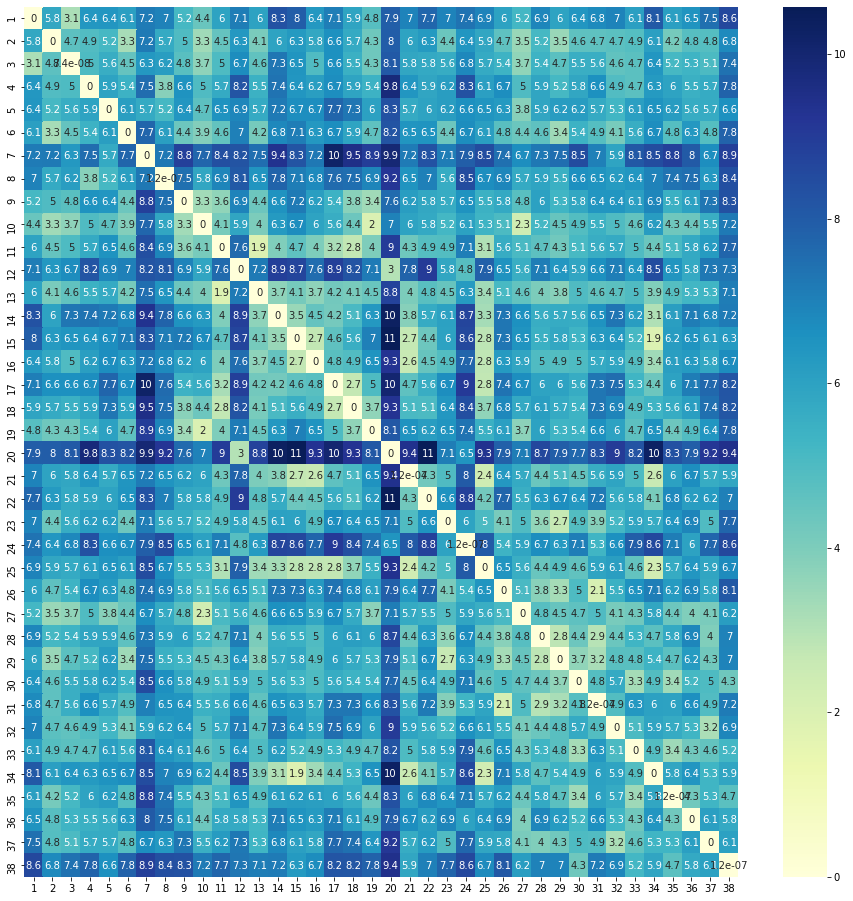

In [25]:
plt.rcParams["figure.figsize"] = (16, 16)
ax = sns.heatmap(distance_matrix, annot=True,cmap="YlGnBu")

Questa heatmap non rende visibili molte informazioni, se non che il campione 20 sembra trovarsi molto distante da tutti i campioni eccezion fatta per il 12, e che sembrano esserci dei minicluster che si possono identificare da quadrati chiari dentro la matrice. Vedremo dopo il clustering come questo apparirà più chiaro.

## Metodi di clustering gerarchico

Sono detti metodi di clustering gerarchico quei metodi che, nell'identificare i cluster, generano un grafo connesso aciclico nel quale le foglie sono i campioni e i nodi sono i cluster o supercluster. Grazie a questo grafo, è possibile rappresentare l'esito di un clustering gerarchico con un dendrogramma.

Possono essere suddivisi in metodi agglomerativi e metodi divisivi; un processo di clustering agglomerativo definisce inizialmente ogni campione come un cluster, e ad ogni iterazione cerca i due cluster più vicini e li unisce in un cluster solo.

Esistono diversi metodi per calcolare la distanza tra cluster con più di un campione, i più semplici sono il Single Linkage, che usa la distanza tra i campioni più vicini di due cluster diversi, il Complete Linkage, che usa la distanza tra i campioni più lontani, e il Centroid Linkage, che usa la distanza tra i centroidi dei cluster.

I metodi divisivi invece partono da un unico cluster, e generano nuovi cluster selezionando elementi dentro il cluster stesso; un metodo è quello di bisezionare il cluster iniziale e continuare a bisezionare tutti i cluster creati fino a che non si arriva ai campioni originali.

Per farlo, si seleziona il membro più distante del cluster, quello con la somma delle distanze dagli altri punti più alta, e lo si usa come centro per creare un secondo cluster, quindi si separano i due cluster così creati.

Questo è un esempio del dendrogramma creato da un algoritmo agglomerativo che usa il Centroid Linkage:

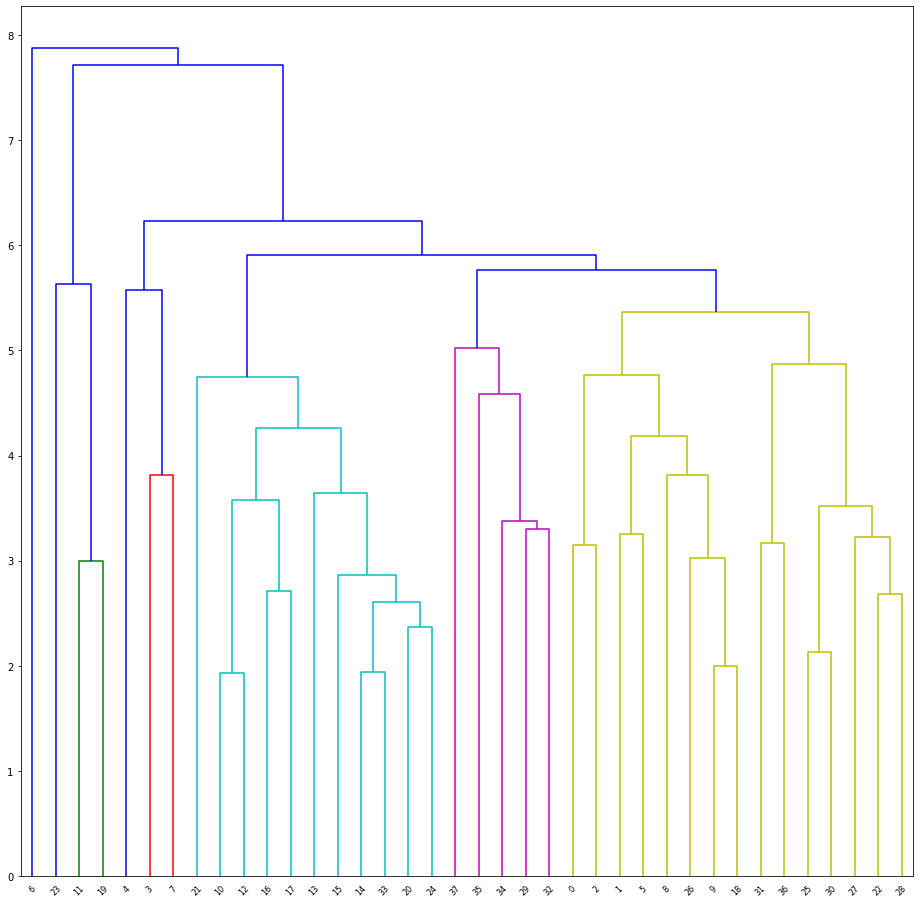

In [26]:
model = AgglomerativeClustering(distance_threshold=5, n_clusters=None, linkage="average")
model = model.fit(pca_df)

plt.rcParams["figure.figsize"] = (16, 16)
counter = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for idx, merge in enumerate(model.children_):
    current = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current += 1
        else:
            current += counter[child_idx - n_samples]
    counter[idx] = current

dendrogram(np.column_stack([model.children_, model.distances_, counter]).astype(float))
plt.show()


Una volta ottenuto il dendrogramma, è possibile scegliere a che livello creare i cluster definendo, in questo caso, la distanza threshold oltre la quale generare il cluster. In questo caso, ad esempio, usando come distanza 5 si ottengono 6 cluster.

## Metodi di clustering non gerarchico

Sotto questo nome sono raggruppati tutti gli altri metodi che non appartengono ai metodi gerarchici, e sono quindi più diversi tra loro.

Uno dei metodi più noti è il k-means, e la sua variante k-means++: si parte dal numero di cluster desiderati, che deve essere noto, e si generano tanti centroidi quanti saranno i cluster.

I centroidi vengono quindi posizionati nello spazio delle variabili, e il posizionamento determina la differenza tra i due metodi: per il k-means è casuale.

Nel k-means++ invece solo il primo centroide è scelto casualmente tra i punti, ogni successivo centroide è scelto tra i punti rimanenti casualmente ma ogni punto ha come probabilità di essere scelto il quadrato della distanza dal centroide più vicino; in questo modo i centroidi saranno meglio suddivisi nello spazio dei punti e il clustering tenderà ad essere più corretto e veloce da ottenere.

Una volta posizionati i centroidi, ogni campione viene assegnato al centroide più vicino, dai cluster così ottenuti si ricalcolano i centroidi e di nuovo si assegnano i campioni ai centroidi più vicini. Questo processo viene ripetuto finchè nessun campione cambia cluster.

Qui vediamo il risultato del clustering usando 4 cluster:

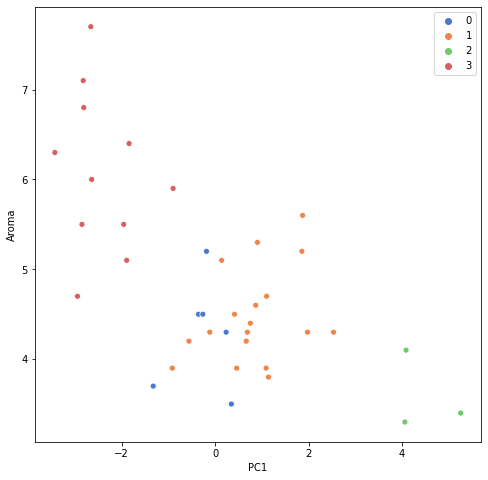

In [27]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pca_df)
plt.rcParams["figure.figsize"] = (8, 8)
ax = sns.scatterplot(data=pca_df, x="PC1", y="Aroma", hue=kmeans.labels_, palette="muted")

Nonostante il clustering sia stato calcolato sulle prime 7 PC, possiamo visualizzare al massimo 2 PC su uno scatterplot, e in questo caso solo la PC1. Risultano comunque abbastanza separati i cluster, e vediamo che uno in particolare (il 3) sembra raggruppare tutti quei campioni che già avevamo evidenziato avere un aroma abbastanza alto e un valore molto basso della PC1.

Per visualizzare l'efficacia del clustering, riproponiamo l'heatmap delle distanze con i campioni ordinati per cluster, e l'ID del cluster tra parentesi dopo il numero del campione:

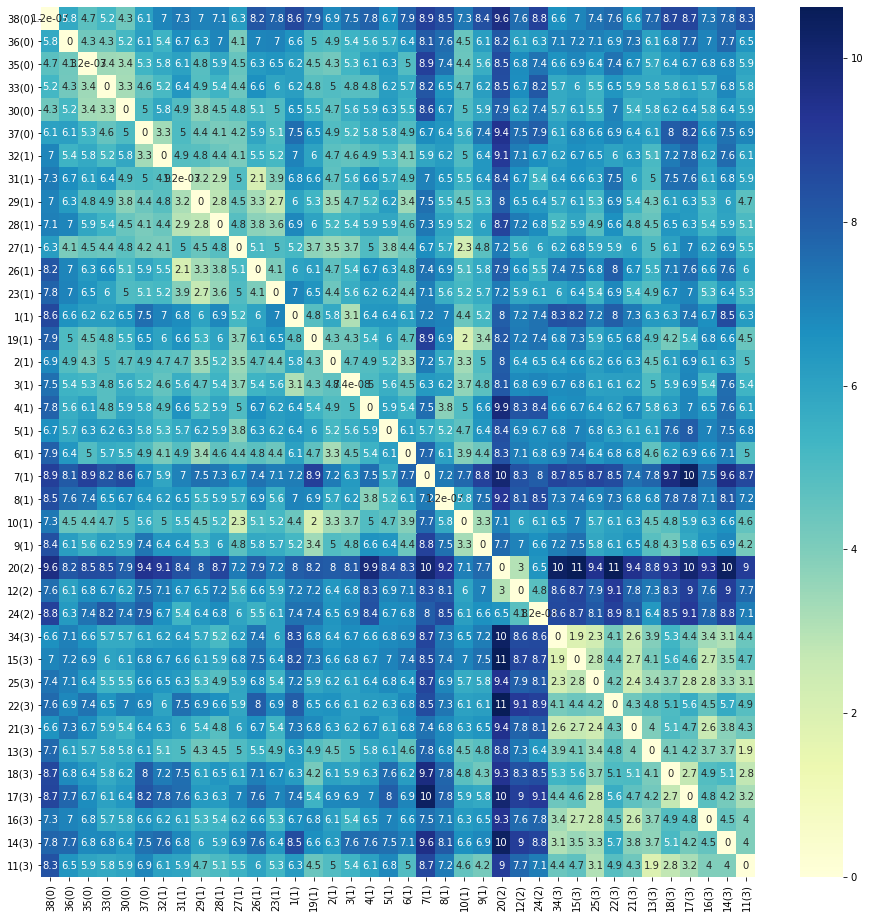

In [28]:
cluster_df = pca_df.assign(Cluster=kmeans.labels_)
cluster_df = cluster_df.sort_values(by="Cluster")
labels = [f"{i+1}({kmeans.labels_[i]})" for i in cluster_df.index]
cluster_distance_matrix = pd.DataFrame(euclidean_distances(cluster_df, cluster_df), columns=labels, index=labels)
plt.rcParams["figure.figsize"] = (16, 16)
ax = sns.heatmap(cluster_distance_matrix, annot=True, cmap="YlGnBu")

Si notano facilmente dei quadrati composti da campioni a distanza minore, molto evidenti per i cluster 3 e 2, meno per i cluster 0 e 1.

# Modello

Il fine ultimo di questa analisi è la costruzione di un modello che sia in grado di spiegare i dati del dataset e predire le variabili dipendenti dalle variabili indipendenti di un nuovo campione sconosciuto.

Il primo step, l'individuazione, consiste nello scegliere il modello adatto al sistema che vogliamo analizzare, tra due classi possibili: modelli deterministici, in cui le relazioni tra le parti del modello sono decise in partenza, e solo introducendo valori casuali si ottengono risultati diversi, e modelli stocastici, in cui solo la forma generale del modello è decisa, ma le interazioni tra le parti si sviluppano partendo dai dati stessi.

In secondo luogo si realizza il modello attraverso il fitting: l'adattamento del modello stocastico ai dati del sistema, grazie alla plasticità dei modelli stocastici e la loro adattabilità.

Si passa quindi alla fase di validazione, in cui il modello viene sottoposto a test e modificato in modo da migliorarne i risultati proprio alla fase di test.

Infine il modello viene applicato su dati reali e sconosciuti, in modo da prevedere come il sistema per il quale è stato costruito si muoverà.

Vengono utilizzati due parametri per definire la capacità di un modello di descrivere il dato noto, R2, e la capacità di prevedere i dati non noti, Q2.

## Validazione

La validazione dei modelli è lo step più delicato, in quanto consiste in un continuo lavoro di affinamento e di ricerca di equilibrio tra le capacità descrittive del modello e le sue capacità di predizione.

Questa ricerca di equilibrio dipende dal fatto che al crescere della complessità di un modello, le sue dimensioni quindi, aumenta l'informazione ricevuta, e di conseguenza aumenta la capacità del modello di descrivere il sistema; questo però avviene a discapito della generalità del modello, che perde la sua capacità di predizione, rimanendo troppo legato ai dati noti.

Per effettuare la validazione si suddivide il dataset iniziale in 2 gruppi di diverse dimensioni: il training e il test set, con il primo che generalmente occupa l'80% del dataset totale.

Il modello, che necessita di dati per essere fittato, riceverà in prima battuta il training set, e successivamente verrà testato contro il test set, utilizzato come se si trattasse di dati nuovi ma dei quali conosciamo la variabile dipendente.

Altri metodi sono il leave-one-out, che genera un modello per ogni campione usando un campione diverso come test set e il resto del dataset come training set, e il leave-more-out, che applica la stessa tecnica ma a più elementi.

La ragione per cui esiste questa divisione del dataset è che all'aumentare del fitting del modello si rischia di incorrere in overfitting, un adattamento innaturale del modello ai dati che rende molto più bassa l'efficienza predittiva.

## La regressione lineare

Nel nostro caso useremo uno dei metodi più semplici e utilizzati per la generazione di un modello: la regressione lineare. Questa tecnica si propone di trovare una funzione lineare in grado di minimizzare lo scarto quadratico medio, ovvero il quadrato della distanza tra le proprie predizioni e i punti reali. Questo metodo può essere utilizzato, come nel nostro caso, anche su dati multivariati.

Il primo step è la generazione dei due set di training e di test, e suddivideremo i campioni tenendo il 25% nel test set e il 75% nel training.

In [29]:
X = scaled_df.drop(["Class", "Aroma"], axis=1)
Y = scaled_df["Aroma"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=18)

lr = LinearRegression()
lr.fit(X_train,Y_train)

pd.DataFrame({
    "R2": [lr.score(X_train, Y_train)],
    "O2": [lr.score(X_test, Y_test)]
}, index = ["Valore"])


,R2,O2
Valore,0.869,0.076


Questi sono i valori di R2 e di O2 ottenuti applicando la regressione lineare sul dataset iniziale; mentre il valore di R2 è molto alto, quindi il modello è altamente descrittivo, O2 è molto basso, il che significa scarsa predittività.

Una prima modifica che possiamo provare è l'uso del dataset ridotto delle PC al posto del dataset completo, per cercare di rimuovere complessità al dataset, seppur mantenendo varianza, e aumentare O2.

In [30]:
def get_pc_results(n_components):
    new_pca = PCA(n_components=n_components)
    new_pca_df = new_pca.fit_transform(scaled_df.drop(["Aroma", "Class"], axis=1))
    new_pca_df = pd.DataFrame(new_pca_df)
    pc_names = [f"PC{i + 1}" for i in range(len(new_pca.explained_variance_))] 
    new_pca_df.columns = pc_names
    X = new_pca_df
    Y = pca_df["Aroma"]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=5)

    lr = LinearRegression()
    lr.fit(X_train,Y_train)
    return lr.score(X_train, Y_train), lr.score(X_test, Y_test)


r2 = []
o2 = []
index = []

for n_components in range(1, 18):
    index.append(f"{n_components} PC")
    results = get_pc_results(n_components)
    r2.append(results[0])
    o2.append(results[1])

pd.DataFrame({
    "R2": r2,
    "O2": o2
}, index = index).transpose()

,1 PC,2 PC,3 PC,4 PC,5 PC,6 PC,7 PC,8 PC,9 PC,10 PC,11 PC,12 PC,13 PC,14 PC,15 PC,16 PC,17 PC
R2,0.406,0.450,0.450,0.609,0.621,0.621,0.638,0.696,0.734,0.779,0.809,0.836,0.845,0.850,0.855,0.861,0.872
O2,0.479,0.503,0.500,0.477,0.593,0.592,0.511,0.278,0.418,0.374,-0.049,-1.612,-0.888,-1.302,-0.751,-0.567,-0.368


Possiamo anche vedere graficamente i due valori:

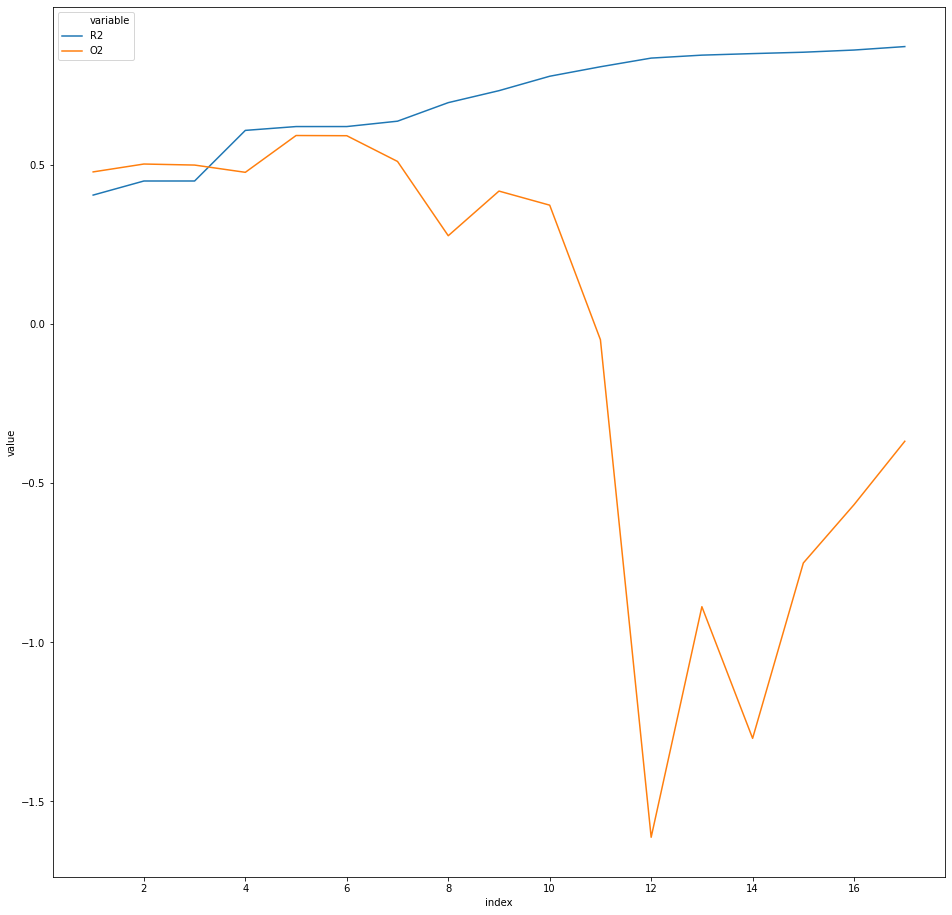

In [31]:
ax = sns.lineplot(data=pd.DataFrame({
    "R2": r2,
    "O2": o2,
    "index": range(1, 18)
}, index=index).melt(id_vars=["index"]), x="index", y="value", hue="variable")

Come ci si può aspettare, all'aumentare delle PC utilizzate, aumenta il valore di R2, mentre quello di O2 precipita dopo le 10 PC ma già scende dopo sole 5 o 6 PC prese in considerazione. Decidiamo quindi di usare le prime 5 PC nella nostra regressione lineare.

### Analisi dei residui

Possiamo effettuare un'analisi dei residui per capire se la regressione lineare è significativa o se stiamo perdendo informazioni circa il modello. Il primo passo è disegnare un QQ plot, che mostra se i residui, o errori, sono distribuiti normalmente o se seguono una specifica funzione.

In [32]:
last_pca = PCA(n_components=5)
last_pca_df = last_pca.fit_transform(scaled_df.drop(["Aroma", "Class"], axis=1))
last_pca_df = pd.DataFrame(last_pca_df)
pc_names = [f"PC{i + 1}" for i in range(len(last_pca.explained_variance_))] 
last_pca_df.columns = pc_names
X = last_pca_df
Y = pca_df["Aroma"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=5)

lr = LinearRegression()
lr.fit(X_train,Y_train)
Y_predict = lr.predict(X.values)

resid_df = pd.DataFrame(X).assign(Aroma=scaled_df["Aroma"], Predicted=Y_predict)
resid_df["Residues"] = resid_df.Aroma - resid_df.Predicted

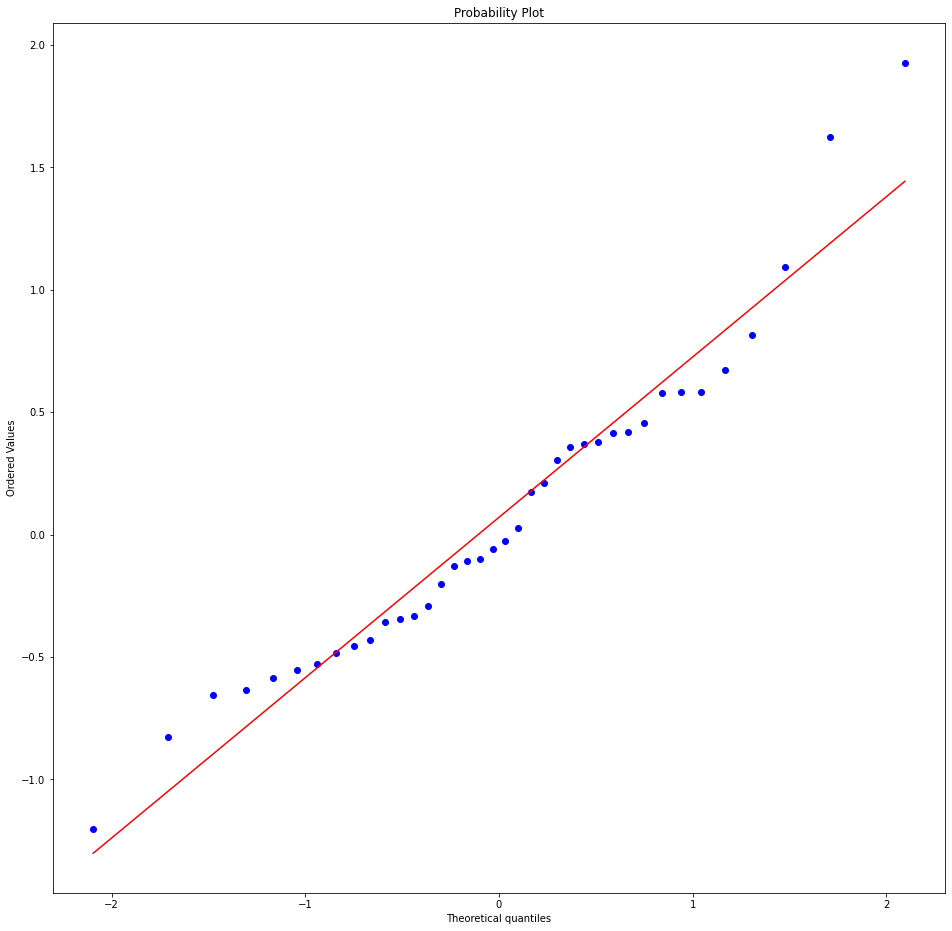

In [33]:
plt.rcParams["figure.figsize"] = (16, 16)
ax = stats.probplot(resid_df.Residues, dist="norm", plot=plt)

Dall'analisi dei residui possiamo vedere che l'aspetto è quello di una funzione con distribuzione normale al centro, ma con dei risultati distanti dall'atteso agli estremi.

Un'altra visualizzazione utile per l'analisi dei residui è plottare i residui contro il valore previsto:

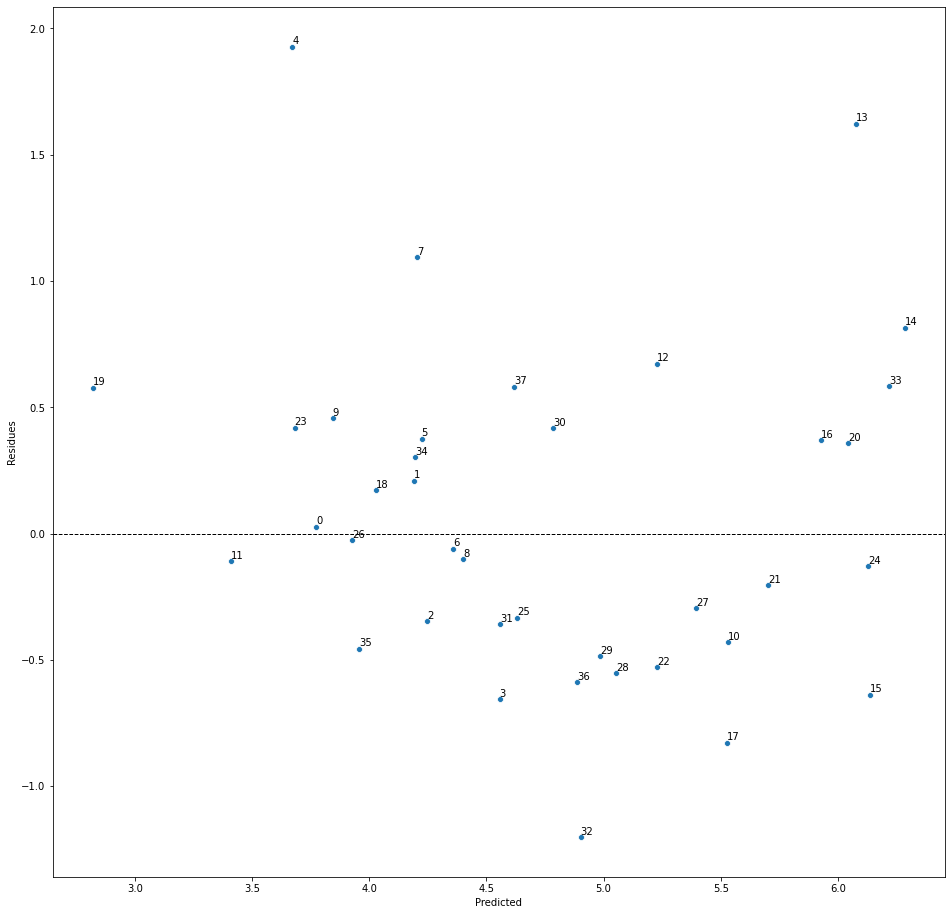

In [34]:
plt.rcParams["figure.figsize"] = (16, 16)
ax = sns.scatterplot("Predicted", "Residues", data=resid_df)
for index in resid_df.index:
    x_coord = resid_df.Predicted[index]
    y_coord = resid_df.Residues[index]
    ax.text(x_coord, y_coord + 0.01, index)
line = ax.axhline(y = 0, color = 'black', linewidth = 1, linestyle = "dashed")

In questo caso, notiamo ancora l'andamento non lineare dei residui del nostro modello, che tende a sottostimare i valori di Aroma.

Identifichiamo facilmente due campioni il cui residuo è molto più grande rispetto agli altri, il 4 e il 13; decidiamo di rimuovere tutti i campioni il cui residuo assoluto è superiore a 1, e a ricalcolare PCA e regressione.

In [35]:
samples_to_drop = [4, 13, 32, 7]
clean_df = scaled_df.drop(samples_to_drop)
clean_pca_df = clean_df.drop(["Aroma", "Class"], axis=1)
last_pca = PCA(n_components=5)
last_pca_df = last_pca.fit_transform(clean_df.drop(["Aroma", "Class"], axis=1))
last_pca_df = pd.DataFrame(last_pca_df)
pc_names = [f"PC{i + 1}" for i in range(len(last_pca.explained_variance_))] 
last_pca_df.columns = pc_names
X = last_pca_df
Y = clean_df["Aroma"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=5)

lr = LinearRegression()
lr.fit(X_train,Y_train)
Y_predict = lr.predict(X.values)

resid_df = pd.DataFrame(X).assign(Aroma=clean_df["Aroma"], Predicted=Y_predict)
resid_df["Residues"] = resid_df.Aroma - resid_df.Predicted

In [36]:
pd.DataFrame({
    "R2": [lr.score(X_train, Y_train)],
    "O2": [lr.score(X_test, Y_test)]
}, index = ["Valore"])


,R2,O2
Valore,0.786,0.693


Come possiamo vedere, la rimozione dei campioni 4, 7, 13 e 32 porta a un netto miglioramento di O2 e R2, che ora assumono valori accettabili per descrivere e avere previsioni di buona accuratezza.

Possiamo quindi vedere i coefficienti della regressione lineare:

In [37]:
pd.DataFrame(lr.coef_.reshape(1, 5), columns=pc_names, index=["Coefficiente"])

,PC1,PC2,PC3,PC4,PC5
Coefficiente,-0.350,0.130,0.062,0.314,0.080


Questi dati confermano quanto visto sia durante la PCA che durante il clustering, che valori alti di PC1 sono indice di basso Aroma; inoltre vediamo come alti valori di PC4 siano indice di alto Aroma.

Possiamo utilizzare questi coefficienti e applicarli ai loading delle PC per vedere i coefficienti delle variabili originarie rispetto al nostro modello:

In [38]:
pd.DataFrame(np.matmul(lr.coef_, last_pca.components_).reshape(1, 17), columns=clean_pca_df.columns, index=["Coefficiente"])

,Cd,Mo,Mn,Ni,Cu,Al,Ba,Cr,Sr,Pb,B,Mg,Si,Na,Ca,P,K
Coefficiente,0.047,0.039,0.039,-0.050,-0.004,-0.143,-0.229,0.017,-0.209,0.026,0.149,-0.185,-0.041,-0.198,-0.115,0.050,-0.100


Vediamo come il nostro modello lineare dia grande importanza a Ba e Sr, che in alte quantità portano a bassi valori di Aroma, mentre alcuni elementi come Cu, Cr e Pb abbiano un'influenza molto bassa sui risultati finali.

## Regressione logistica

Mentre la regressione lineare si usa per stimare valori continui, possiamo utilizzare un modello diverso per stimare valori categorici come la classe. Anche in questo caso utilizziamo uno dei modelli più diffusi, la regressione logistica.

Questo metodo si usa per prevedere una variabile dipendente categorica, quindi non continua, e il risultato è la probabilità che un dato set di variabili indipendenti appartenga ad una classe.

Poichè si tratta comunque di un'operazione lineare, il presupposto per una buona efficacia è che nello spazio delle variabili utilizzate ci sia una suddivisione tra i punti appartenenti alle diverse classi rappresentabile da un piano. Questa separazione e le coordinate del piano sono il threshold che la regressione punta a individuare.

Partendo da questa informazione, si può capire come in questo caso un numero maggiore di dimensioni non va sempre a detrimento dei risultati: in uno spazio con più dimensioni è più semplice trovare il piano (iperpiano) che separi due gruppi di punti.

In [39]:
def get_pc_results(n_components):
    new_pca = PCA(n_components=n_components)
    new_pca_df = new_pca.fit_transform(scaled_df.drop(["Aroma", "Class"], axis=1))
    new_pca_df = pd.DataFrame(new_pca_df)
    pc_names = [f"PC{i + 1}" for i in range(len(new_pca.explained_variance_))] 
    new_pca_df.columns = pc_names
    X = new_pca_df
    Y = pca_df["Class"]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

    lr = LogisticRegression()
    lr.fit(X_train,Y_train)
    return lr.score(X_train, Y_train), lr.score(X_test, Y_test)


r2 = []
o2 = []
index = []

for n_components in range(1, 18):
    index.append(f"{n_components} PC")
    results = get_pc_results(n_components)
    r2.append(results[0])
    o2.append(results[1])

pd.DataFrame({
    "R2": r2,
    "O2": o2
}, index = index).transpose()

,1 PC,2 PC,3 PC,4 PC,5 PC,6 PC,7 PC,8 PC,9 PC,10 PC,11 PC,12 PC,13 PC,14 PC,15 PC,16 PC,17 PC
R2,0.786,0.714,0.714,0.750,0.750,0.679,0.786,0.857,0.929,0.929,0.929,0.929,0.929,0.929,0.929,0.929,0.929
O2,0.800,0.800,0.800,0.800,0.800,0.800,0.900,0.500,0.700,0.700,0.700,0.700,0.700,0.700,0.700,0.700,0.700


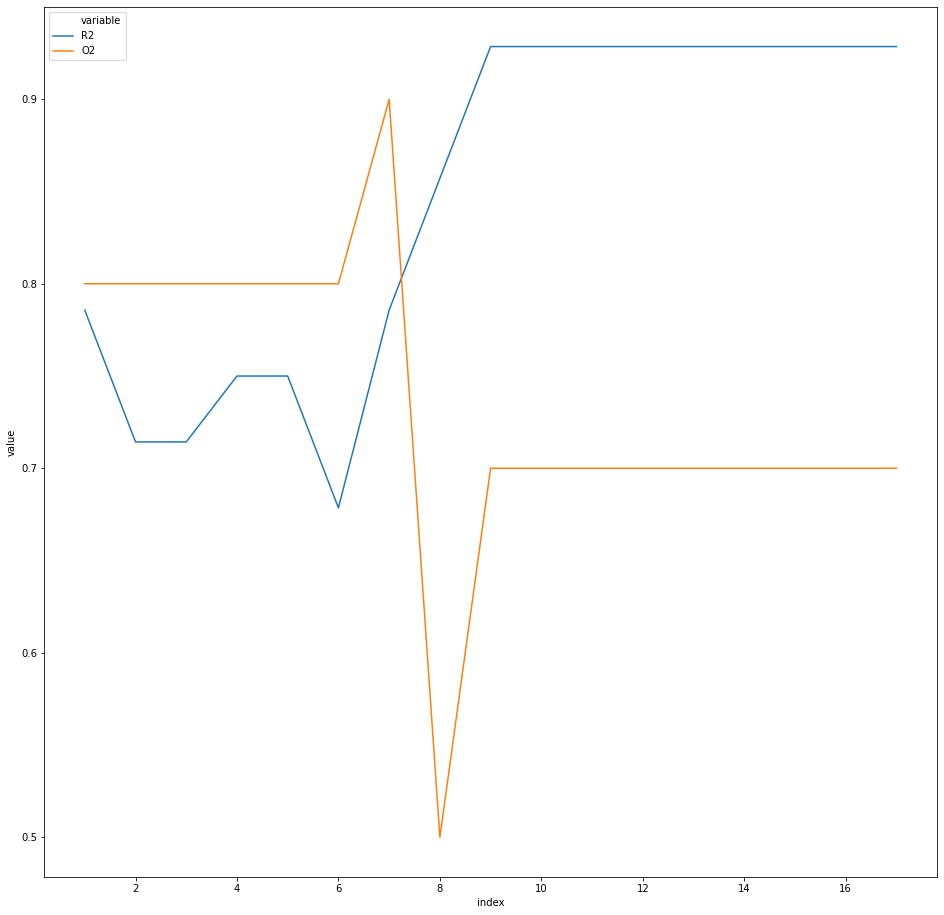

In [40]:
plt.rcParams["figure.figsize"] = (16, 16)

ax = sns.lineplot(data=pd.DataFrame({
    "R2": r2,
    "O2": o2,
    "index": range(1, 18)
}, index=index).melt(id_vars=["index"]), x="index", y="value", hue="variable")

Vediamo infatti che, mentre R2 continua a crescere come atteso, O2 non subisce il crollo che ci si aspetta nella regressione lineare, ma mantiene valori accettabili anche usando tutte le PC. Il risultato migliore si ottiene, comunque, con 7 PC.

Poichè non esistono i residui nella regressione logistica, per visualizzare il risultato della nostra analisi usiamo la matrice di confusione, che rappresenta per ogni classe la percentuale di errori e di predizioni corrette:

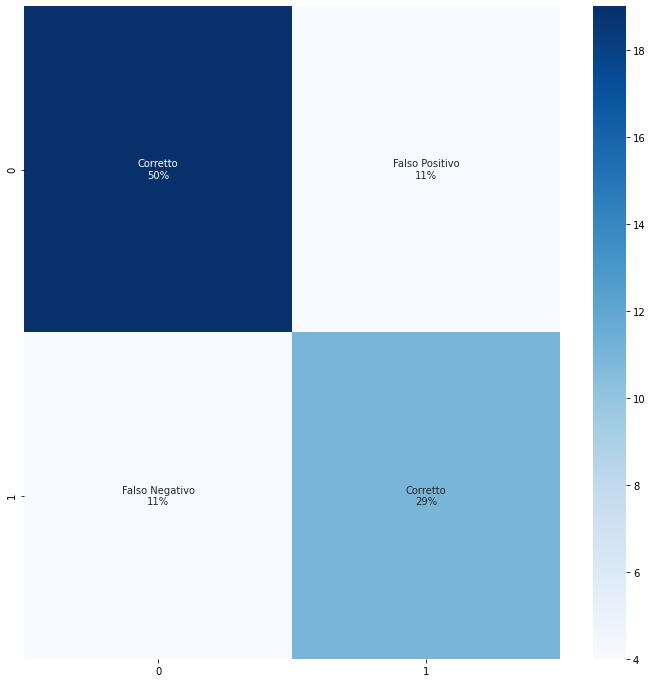

In [41]:
last_pca = PCA(n_components=5)
last_pca_df = last_pca.fit_transform(scaled_df.drop(["Aroma", "Class"], axis=1))
last_pca_df = pd.DataFrame(last_pca_df)
pc_names = [f"PC{i + 1}" for i in range(len(last_pca.explained_variance_))] 
last_pca_df.columns = pc_names
X = last_pca_df
Y = pca_df["Class"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=5)

lr = LogisticRegression()
lr.fit(X_train,Y_train)
Y_predict = lr.predict(X.values)

resid_df = pd.DataFrame(X).assign(Aroma=scaled_df["Aroma"], Predicted=Y_predict)
resid_df["Residues"] = resid_df.Aroma - resid_df.Predicted

Y_predict = lr.predict(X.values)
conf_matrix = confusion_matrix(Y, Y_predict)
square_names = ["Corretto", "Falso Positivo", "Falso Negativo", "Corretto"]
square_perc = [round(value * 100) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}%" for v1, v2 in zip(square_names, square_perc)]
labels = np.asarray(labels).reshape(2,2)

plt.rcParams["figure.figsize"] = (12, 12)
ax = sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues')

Vediamo che la predizione su tutto il dataset è corretta il 76% delle volte, mentre gli errori di classificazione sembrano essere equivalenti tra le due classi. Questo però può essere influenzato dalla sovrarappresentazione di una classe rispetto all'altra, soprattutto in dataset piccoli come il nostro.

Anche in questo caso vediamo i coefficienti delle PC e dei dati originali:

In [42]:
pd.DataFrame(lr.coef_.reshape(1, 5), columns=pc_names, index=["Coefficiente"])

,PC1,PC2,PC3,PC4,PC5
Coefficiente,-0.782,0.710,0.099,0.485,0.658


In [43]:
pd.DataFrame(np.matmul(lr.coef_, last_pca.components_).reshape(1, 17), columns=clean_pca_df.columns, index=["Coefficiente"])

,Cd,Mo,Mn,Ni,Cu,Al,Ba,Cr,Sr,Pb,B,Mg,Si,Na,Ca,P,K
Coefficiente,0.119,0.403,-0.053,-0.075,0.357,-0.262,-0.666,0.207,-0.580,0.339,0.296,-0.389,-0.146,-0.296,-0.083,0.198,-0.286


Anche in questo caso, Ba e Sr sono forti indici di classe 1, mentre acquistano maggiore importanza alcuni elementi come Cu e Mo. Questo dipende probabilmente dal fatto che la classe è una variabile più semplice dell'aroma.

# Conclusione

L'obbiettivo finale del progetto era di ottenere un modello descrittivo e predittivo del sistema descritto dal dataset iniziale, e per farlo abbiamo dovuto studiare la struttura e le caratteristiche del dataset, scegliere quanta informazione mantenere nel modello finale e perfezionarlo una volta costruito il primo.

Il primo modello ottenuto è una regressione lineare multivariata, ovvero una combinazione lineare di variabili indipendenti che prevede il valore di una singola variabile indipendente. Poichè siamo partiti dalle PC, che a loro volta sono ottenute da combinazioni lineari delle variabili originarie, il modello che otteniamo è semplificabile a una combinazione lineare delle variabili originarie.

Il vantaggio principale di un modello così semplice è che ci consente di trarre conclusioni sul nostro sistema in quanto interpretabile facilmente: si tratta di coefficienti per i quali vanno moltiplicate le variabili originarie, e nel nostro caso abbiamo visto che è possibile comprendere l'effetto di diversi elementi sull'output del modello anche singolarmente.

Modelli più complessi, come quelli polinomiali, le reti neurali o random forest, possono offrire migliori risultati nella predizione delle variabili dipendenti ma risultano molto più complessi da interpretare.

Il secondo modello, più semplice in quanto limitato alla previsione della classe di appartenenza e non di un valore continuo, fin da subito e senza doverlo rifinire consente di avere buoni risultati di predizione e descrizione, ma l'output è una variabile meno informazionale sul nostro sistema.

Eventuali futuri step potrebbero essere sicuramente l'aggiunta di nuovi campioni nel dataset e l'esplorazione di modelli più complessi al fine di ottenere predizioni più precise.

Di seguito, la tabella dei valori originali:

In [44]:
df

,Cd,Mo,Mn,Ni,Cu,Al,Ba,Cr,Sr,Pb,B,Mg,Si,Na,Ca,P,K,Aroma,Class,Id
0,0.005,0.044,1.510,0.122,0.830,0.982,0.387,0.029,1.230,0.561,2.630,128.000,17.300,66.800,80.500,150.000,1130,3.800,1,1
1,0.055,0.160,1.160,0.149,0.066,1.020,0.312,0.038,0.975,0.697,6.210,193.000,19.700,53.300,75.000,118.000,1010,4.400,1,2
2,0.056,0.146,1.100,0.088,0.643,1.290,0.308,0.035,1.140,0.730,3.050,127.000,15.800,35.400,91.000,161.000,1160,3.900,1,3
3,0.063,0.191,0.959,0.380,0.133,1.050,0.165,0.036,0.927,0.796,2.570,112.000,13.400,27.500,93.600,120.000,924,3.900,1,4
4,0.011,0.363,1.380,0.160,0.051,1.320,0.380,0.059,1.130,1.730,3.070,138.000,16.700,76.600,84.600,164.000,1090,5.600,2,5
5,0.050,0.106,1.250,0.114,0.055,1.270,0.275,0.019,1.050,0.491,6.560,172.000,18.700,15.700,112.000,137.000,1290,4.600,1,6
6,0.025,0.479,1.070,0.168,0.753,0.715,0.164,0.062,0.823,2.060,4.570,179.000,17.800,98.500,122.000,184.000,1170,4.300,1,7
7,0.024,0.234,0.906,0.466,0.102,0.811,0.271,0.044,0.963,1.090,3.180,145.000,14.300,10.500,91.900,187.000,1020,5.300,2,8
8,0.009,0.058,1.840,0.042,0.170,1.800,0.225,0.022,1.130,0.048,6.130,113.000,13.000,54.400,70.200,158.000,1240,4.300,1,9
9,0.033,0.074,1.280,0.098,0.053,1.350,0.329,0.030,1.070,0.552,3.300,140.000,16.300,70.500,74.700,159.000,1100,4.300,1,10
